In [1]:
library(grDevices)
library(mclust)
library(plyr)
library(RColorBrewer)
library(SingleCellExperiment)
library(slingshot)
library(stringr)

Package 'mclust' version 5.4.10
Type 'citation("mclust")' for citing this R package in publications.

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbin

# Setting file paths

In [2]:
SERGIO_DATASETS_DIR = '/scratch/ch153/packages/SERGIO/PayamDiba/SERGIO/data_sets'
INPUTS_BEELINE_DIR = '/scratch/ch153/packages/BEELINE/hlab1/Beeline/inputs_beeline'

# Testing bifurcation dataset with 4 cell types

In [3]:
expfile = file.path(SERGIO_DATASETS_DIR,'De-noised_100G_4T_300cPerT_dynamics_10_DS5/simulated_noNoise_T_0.csv')
exp = read.table(expfile,sep=',',header=TRUE,row.names=1)
rownames(exp) = paste0('G',rownames(exp))
head(exp)
dim(exp)

,X0,X0.1,X0.2,X0.3,X0.4,X0.5,X0.6,X0.7,X0.8,X0.9,⋯,X3.290,X3.291,X3.292,X3.293,X3.294,X3.295,X3.296,X3.297,X3.298,X3.299
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
G0,8.855860,8.247619,7.480713,7.945972,8.836064,8.816258,9.639781,9.040885,8.041328,8.397500,⋯,37.370620,16.954905,23.151802,25.996842,29.140317,35.686134,28.479042,26.252019,32.568779,32.234494
G1,2.192947,2.150170,1.834827,2.412325,1.634739,2.137678,1.672804,1.925791,2.540002,3.017806,⋯,3.604069,1.474855,2.924327,3.382615,3.427355,4.968921,3.142765,3.417344,2.814453,2.552498
G2,20.571664,16.782409,20.076520,19.145448,20.304858,18.880273,19.780865,19.628338,19.659809,16.615581,⋯,14.978986,20.608223,16.549215,17.467195,14.582750,15.931394,17.176188,17.109416,18.925692,19.499690
G3,11.893102,11.859898,12.970607,12.448558,11.940408,13.275850,13.116533,13.260146,12.366383,11.505595,⋯,9.152342,13.749956,12.136588,12.170649,11.242504,10.106880,9.671960,11.567360,13.295088,13.618158
G4,22.331774,22.413572,24.410942,23.920567,24.025329,22.120312,24.081389,22.765010,22.702896,19.826397,⋯,48.958651,36.880105,40.351943,41.426109,43.816513,45.916286,44.514932,42.135005,47.830103,53.755524
G5,2.220126,1.893115,2.046151,1.858205,1.524885,1.811780,1.766752,1.568121,2.867770,1.709418,⋯,4.826828,1.478101,2.011863,2.904145,2.768775,3.073416,2.786245,2.736595,2.593242,2.838523


[1]  100 1200

In [4]:
cids = sapply(strsplit(colnames(exp),'\\.'),`[`,1)
head(cids)

[1] "X0" "X0" "X0" "X0" "X0" "X0"

In [5]:
sce <- SingleCellExperiment(assays = List(norm = as.matrix(exp)))
sce

class: SingleCellExperiment 
dim: 100 1200 
metadata(0):
assays(1): norm
rownames(100): G0 G1 ... G98 G99
rowData names(0):
colnames(1200): X0 X0.1 ... X3.298 X3.299
colData names(0):
reducedDimNames(0):
spikeNames(0):

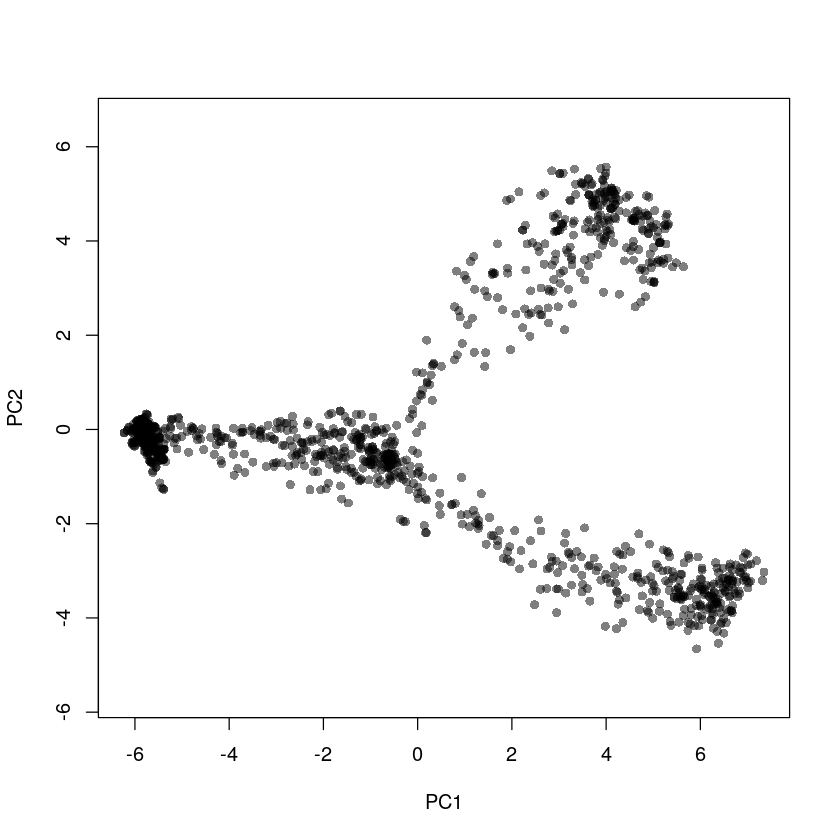

In [6]:
pca <- prcomp(t(log1p(assays(sce)$norm)), scale. = FALSE)
rd1 <- pca$x[,1:2]

plot(rd1, col = rgb(0,0,0,.5), pch=16, asp = 1)

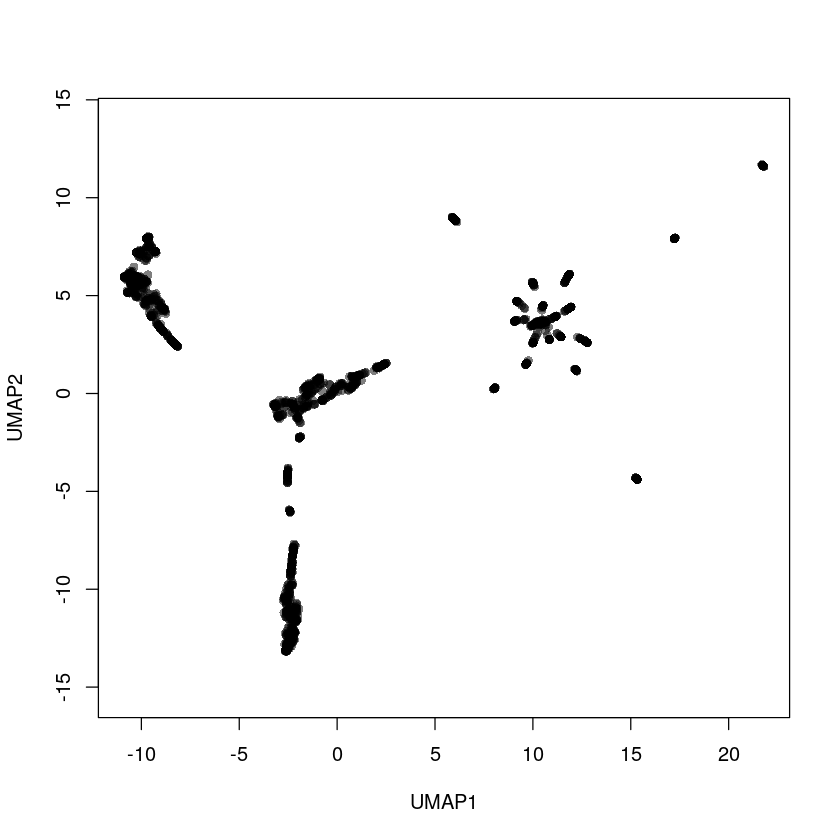

In [7]:
rd2 <- uwot::umap(t(log1p(assays(sce)$norm)))
colnames(rd2) <- c('UMAP1', 'UMAP2')

plot(rd2, col = rgb(0,0,0,.5), pch=16, asp = 1)

In [8]:
reducedDims(sce) <- SimpleList(PCA = rd1, UMAP = rd2)
colData(sce)

DataFrame with 1200 rows and 0 columns

In [9]:
cl1 <- kmeans(rd1, centers = 4)$cluster
colData(sce)$pca_km <- cl1
head(cl1)
cl2 <- kmeans(rd2, centers = 4)$cluster
colData(sce)$umap_km <- cl2
head(cl2)

X0 X0.1 X0.2 X0.3 X0.4 X0.5 
   1    1    1    1    1    1

[1] 3 3 3 3 3 3

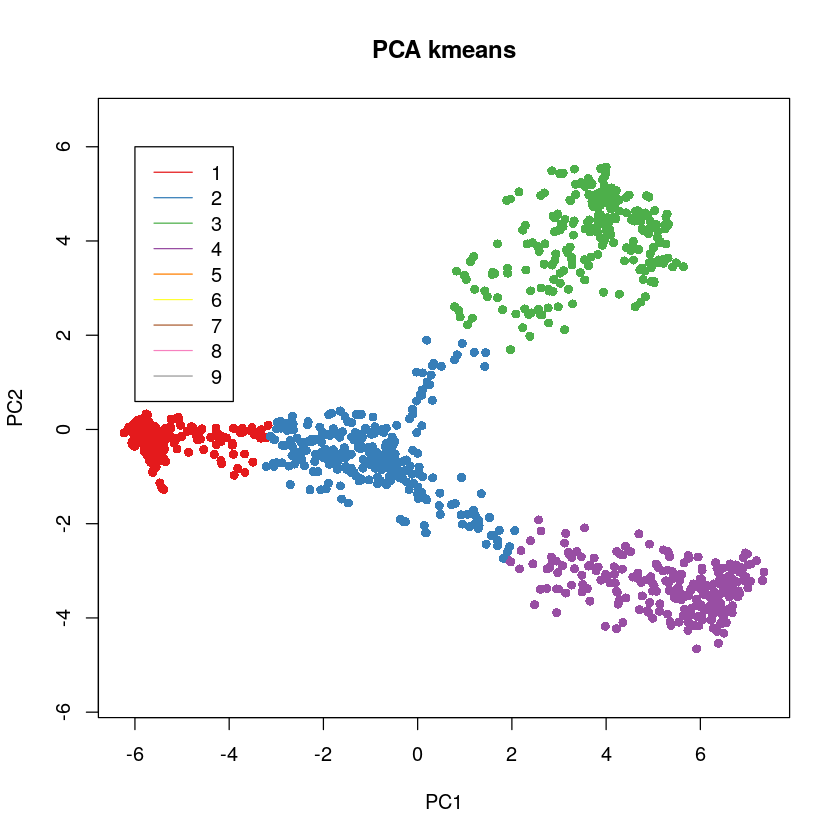

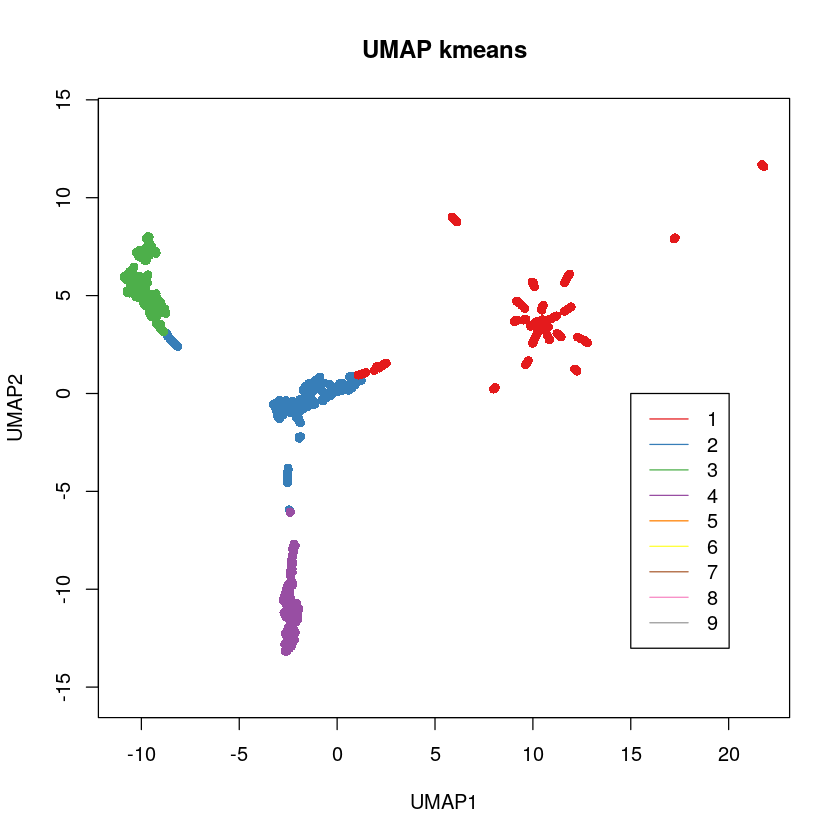

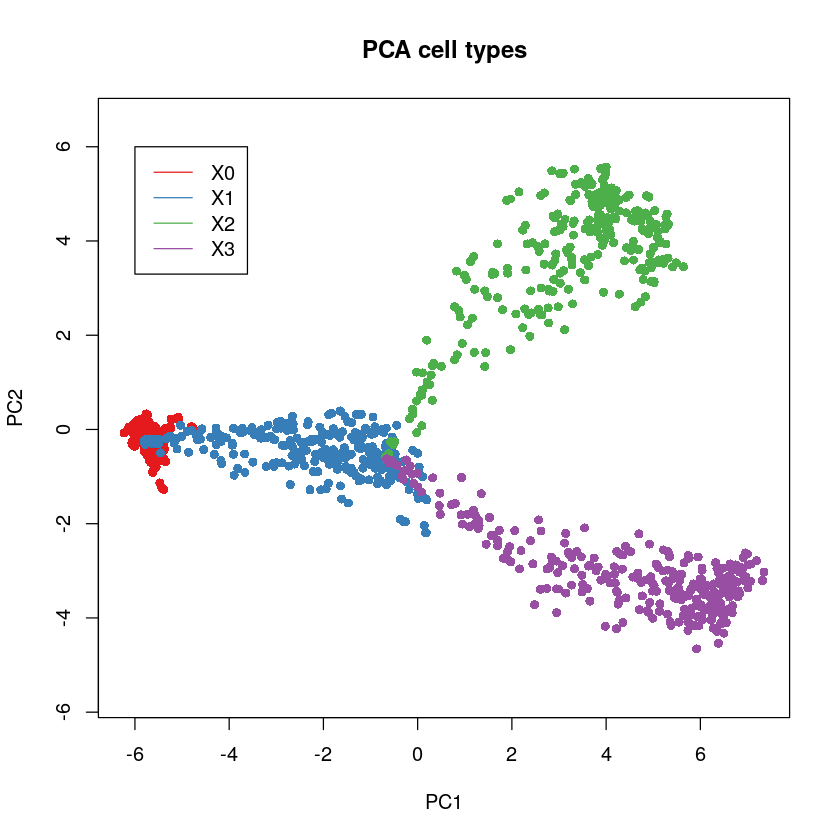

In [10]:
plot(rd1, col = brewer.pal(9,"Set1")[cl1], pch=16, asp = 1,main="PCA kmeans")
legend(-6,6, legend=1:9,
       col=brewer.pal(9,"Set1"), lty=1)
plot(rd2, col = brewer.pal(9,"Set1")[cl1], pch=16, asp = 1,main="UMAP kmeans")
legend(15,0, legend=1:9,
       col=brewer.pal(9,"Set1"), lty=1)
plot(rd1, col = brewer.pal(9,"Set1")[as.factor(cids)], pch=16, asp = 1,main="PCA cell types")
legend(-6,6, legend=levels(as.factor(cids)),
       col=brewer.pal(9,"Set1"), lty=1)

In [11]:
sce <- slingshot(sce, clusterLabels = cids, reducedDim = 'PCA')

Using full covariance matrix

Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to

In [48]:
ptValues <- slingPseudotime(sce)
nPT = ncol(ptValues)
for (pt_i in 1:nPT) {
    ptCol = paste0('slingPseudotime_',pt_i)
    print(summary(colData(sce)[,ptCol]))
}

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.0000  0.5724  4.2902  5.2077 10.5667 13.0629     328 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.0000  0.5987  4.4947  5.3459 10.0838 14.0736     298 


[1] 1
[1] 2


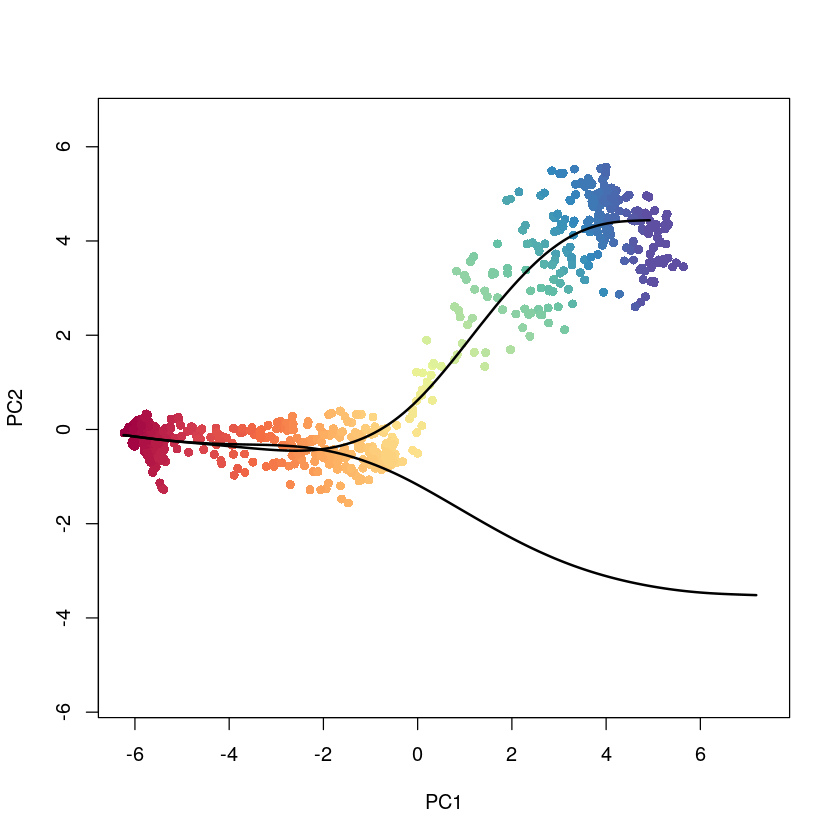

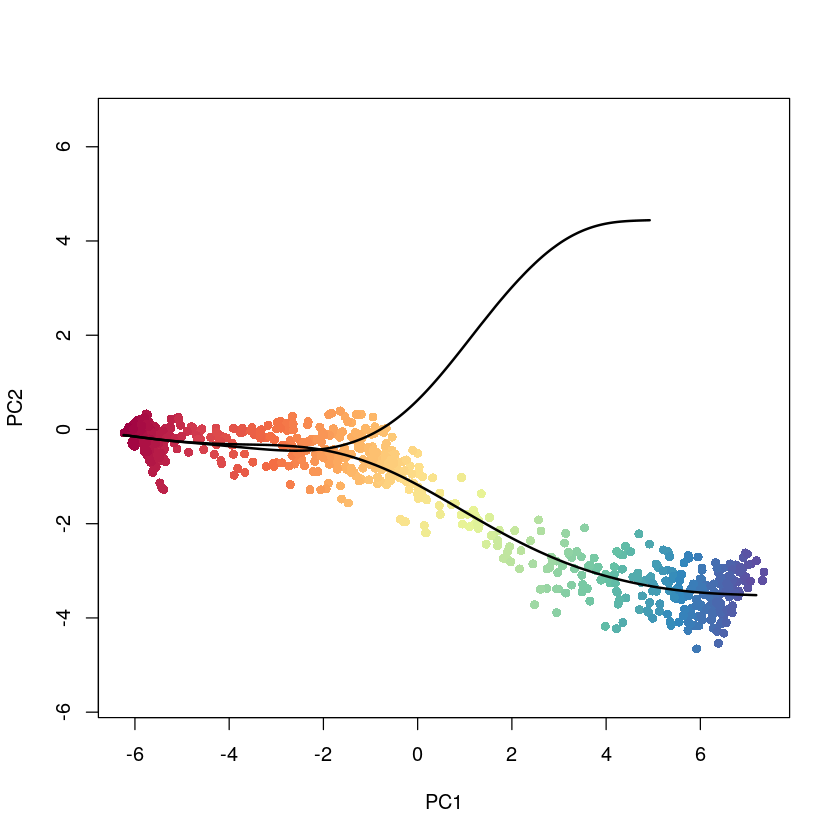

In [52]:
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)

for (pt_i in 1:nPT) {
    print(pt_i)
    ptCol = paste0('slingPseudotime_',pt_i)
    plotcol <- colors[cut(colData(sce)[,ptCol], breaks=100)]
    plot(reducedDims(sce)$PCA, col = plotcol, pch=16, asp = 1)
    lines(SlingshotDataSet(sce), lwd=2, col='black')
}

In [14]:
colnames(ptValues) <- gsub("curve", "PseudoTime",colnames(ptValues))
head(ptValues)

ds <- list()
for (col in colnames(ptValues)){
    idx <- !is.na(ptValues[,col])
    x <- as.numeric(rd1[idx,1])
    y <- as.numeric(rd1[idx,2])
    lo <- loess(y~x)

    ypred <- predict(lo,x)
    ds[paste0('y',col)] <- list(as.character(ypred))
    ds[paste0('x',col)] <- list(as.character(x))
}

,PseudoTime1,PseudoTime2
X0,0.4577148,0.4577180
X0.1,0.4130402,0.4130423
X0.2,0.6514122,0.6516343
X0.3,0.5464660,0.5463405
X0.4,0.7605156,0.7593760
X0.5,0.2878811,0.2878826


In [15]:
ds[['xPseudoTime1']][1:10]
ds[['yPseudoTime1']][1:10]

[1] "-5.78029506310465" "-5.81116790101724" "-5.56271062717818"
 [4] "-5.73991439399076" "-5.55089340405467" "-5.96215795164028"
 [7] "-5.51149852862836" "-5.89909013886888" "-5.08394829069345"
[10] "-5.61416436444533"

[1] "-0.158423471779201" "-0.148918320210171" "-0.22299977066783" 
 [4] "-0.170597867087376" "-0.226439500414527" "-0.101990536121454"
 [7] "-0.237839830304503" "-0.121649024569264" "-0.352306114273205"
[10] "-0.207924530043885"

In [16]:
ssCurves = slingCurves(sce)
names(ssCurves[['curve1']])
head(ssCurves[['curve1']][['s']])

[1] "s"        "ord"      "lambda"   "dist_ind" "dist"     "w"

,PC1,PC2
X0,-5.784004,-0.1782067
X0.1,-5.828319,-0.1725499
X0.2,-5.591790,-0.2021289
X0.3,-5.695952,-0.1893225
X0.4,-5.483436,-0.2148947
X0.5,-5.952458,-0.1566020


[1] 1
[1] 2


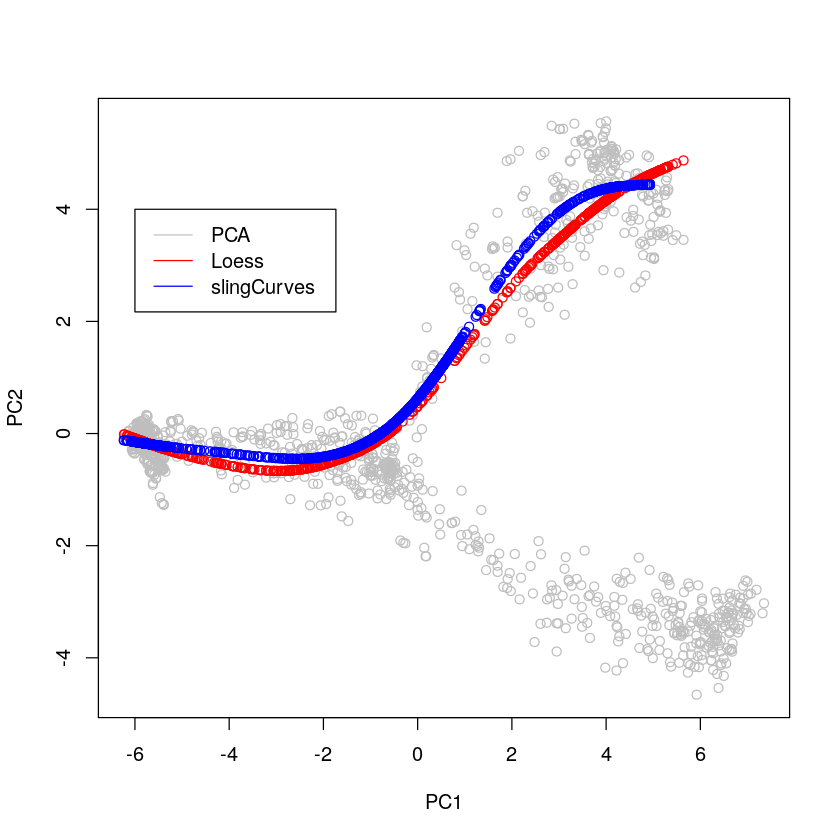

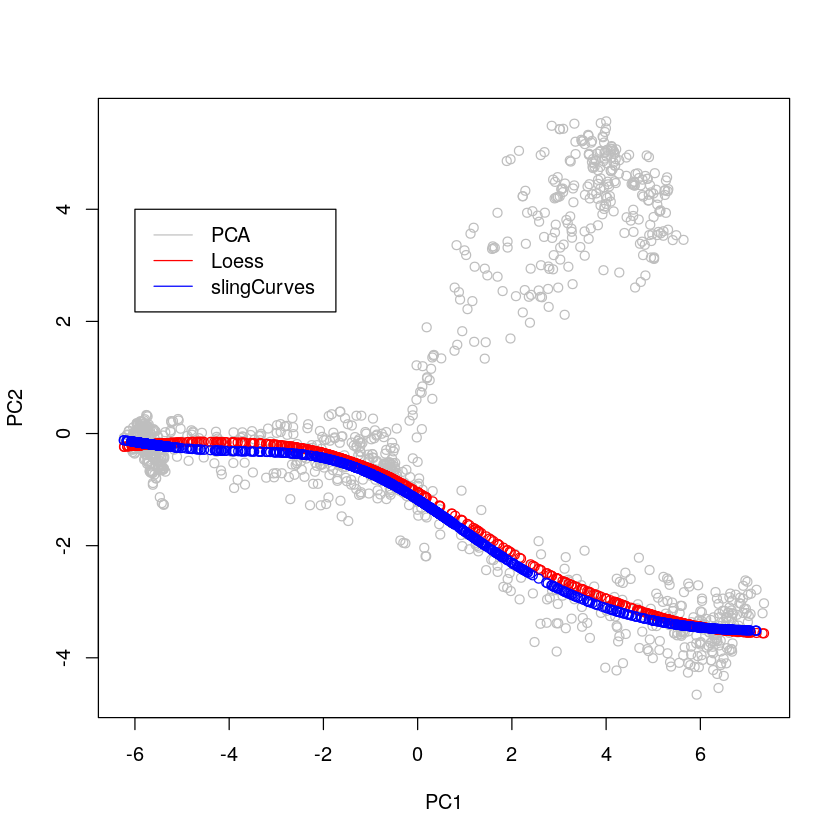

In [55]:
for (pt_i in 1:nPT) {
    print(pt_i)
    ptCol = paste0('PseudoTime',pt_i)
    plot(PC2~PC1,data=rd1,col='grey')
    points(ds[[paste0('x',ptCol)]],ds[[paste0('y',ptCol)]],col='red')
    points(PC2~PC1,data=ssCurves[[paste0('curve',pt_i)]][['s']],col='blue')
    legend(-6,4,legend=c('PCA','Loess','slingCurves'),col=c('grey','red','blue'),lty=1)
}

## Create function to run all datasets

In [58]:
run_slingshot<-function(expfile,cluster_k,main,outdir) {
    exp = read.table(expfile,sep=',',header=TRUE,row.names=1)
    rownames(exp) = paste0('G',rownames(exp))
    print(paste(main,'Expression data'))
    head(exp)
    dim(exp)
    print(paste(main,'Cluster IDs'))
    cids = sapply(strsplit(colnames(exp),'\\.'),`[`,1)
    head(cids)
    colnames(exp) = paste0('E',0:(ncol(exp)-1))
    
    print(paste(main,'SingleCellExperiment'))
    sce <- SingleCellExperiment(assays = List(norm = as.matrix(exp)))
    sce
    
    print(paste(main,'PCA'))
    pca <- prcomp(t(log1p(assays(sce)$norm)), scale. = FALSE)
    rd1 <- pca$x[,1:2]
    plot(rd1, col = rgb(0,0,0,.5), pch=16, asp = 1,main=paste(main,'PCA'))
    
    print(paste(main,'UMAP'))
    rd2 <- uwot::umap(t(log1p(assays(sce)$norm)))
    colnames(rd2) <- c('UMAP1', 'UMAP2')
    plot(rd2, col = rgb(0,0,0,.5), pch=16, asp = 1,main=paste(main,'UMAP'))
    
    reducedDims(sce) <- SimpleList(PCA = rd1, UMAP = rd2)
    print(paste(main,'PCA kmeans'))
    cl1 <- kmeans(rd1, centers = cluster_k)$cluster
    colData(sce)$pca_km <- cl1
    head(cl1)
    print(paste(main,'UMAP kmeans'))
    cl2 <- kmeans(rd2, centers = cluster_k)$cluster
    colData(sce)$umap_km <- cl2
    head(cl2)
    
    plot(rd1, col = brewer.pal(9,"Set1")[cl1], pch=16, asp = 1,main=paste(main,"PCA kmeans"))
    legend(-6,6, legend=1:9,
           col=brewer.pal(9,"Set1"), lty=1)
    plot(rd2, col = brewer.pal(9,"Set1")[cl1], pch=16, asp = 1,main=paste(main,"UMAP kmeans"))
    legend(15,0, legend=1:9,
           col=brewer.pal(9,"Set1"), lty=1)
    plot(rd1, col = brewer.pal(9,"Set1")[as.factor(cids)], pch=16, asp = 1,main=paste(main,"PCA cell types"))
    legend(-6,6, legend=levels(as.factor(cids)),
           col=brewer.pal(9,"Set1"), lty=1)
    
    print(paste(main,'Slingshot'))
    sce <- slingshot(sce, clusterLabels = cids, reducedDim = 'PCA')
    ptValues <- slingPseudotime(sce)
    nPT = ncol(ptValues)
    print(paste(main,'Slingshot PseudoTime summary'))    
    for (pt_i in 1:nPT) {
        ptCol = paste0('slingPseudotime_',pt_i)
        print(summary(colData(sce)[,ptCol]))
    }
    
    colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
    for (pt_i in 1:nPT) {
        ptCol = paste0('slingPseudotime_',pt_i)
        plotcol <- colors[cut(colData(sce)[,ptCol], breaks=100)]
        plot(reducedDims(sce)$PCA, col = plotcol, pch=16, asp = 1,main=paste(main,ptCol))
        lines(SlingshotDataSet(sce), lwd=2, col='black')
    }
    
#    plotcol <- colors[cut(sce$slingPseudotime_1, breaks=100)]
#    plot(reducedDims(sce)$PCA, col = plotcol, pch=16, asp = 1, main=paste(main,"slingPseudotime_1"))
#    lines(SlingshotDataSet(sce), lwd=2, col='black')

    #plotcol <- colors[cut(sce$slingPseudotime_2, breaks=100)]
    #plot(reducedDims(sce)$PCA, col = plotcol, pch=16, asp = 1,main=paste(main,"slingPseudotime_2"))
    #lines(SlingshotDataSet(sce), lwd=2, col='black')

    print(paste(main,'LOESS fit principal curves'))
    ptValues <- slingPseudotime(sce)
    colnames(ptValues) <- gsub("curve", "PseudoTime",colnames(ptValues))
    head(ptValues)
    ds <- list()
    for (col in colnames(ptValues)){
        idx <- !is.na(ptValues[,col])
        x <- as.numeric(rd1[idx,1])
        y <- as.numeric(rd1[idx,2])
        lo <- loess(y~x)

        ypred <- predict(lo,x)
        ds[paste0('y',col)] <- list(as.character(ypred))
        ds[paste0('x',col)] <- list(as.character(x))
    }
    
    print(paste(main,'Slingshot principal curves'))
    ssCurves = slingCurves(sce)    
    names(ssCurves) = gsub("curve", "PseudoTime",names(ssCurves))
    ds2 <- list()
    for (col in colnames(ptValues)){
        print(col)
        x <- as.numeric(ssCurves[[col]][['s']][,'PC1'])
        y <- as.numeric(ssCurves[[col]][['s']][,'PC2'])

        ds2[paste0('y',col)] <- list(as.character(y))
        ds2[paste0('x',col)] <- list(as.character(x))
    }
    
    for (pt_i in 1:nPT) {
        #print(pt_i)
        ptCol = paste0('PseudoTime',pt_i)
        plot(PC2~PC1,data=rd1,col='grey',main=paste(main,"principal curves",pt_i))
        points(ds[[paste0('x',ptCol)]],ds[[paste0('y',ptCol)]],col='red')
        points(PC2~PC1,data=ssCurves[[ptCol]][['s']],col='blue')
        legend(-6,4,legend=c('PCA','Loess','slingCurves'),col=c('grey','red','blue'),lty=1)
    }
    
    #plot(PC2~PC1,data=rd1,col='grey',main=paste(main,"principal curves"))
    #points(ds[['xPseudoTime1']],ds[['yPseudoTime1']],col='red')
    #points(ds[['xPseudoTime2']],ds[['yPseudoTime2']],col='red')
    #points(PC2~PC1,data=ssCurves[['PseudoTime1']][['s']],col='blue')
    #points(PC2~PC1,data=ssCurves[['PseudoTime2']][['s']],col='blue')
    #legend(-6,4,legend=c('PCA','Loess','slingCurves'),col=c('grey','red','blue'),lty=1)
    
    write.table(ptValues,file.path(outdir,'SlingshotPT.csv'),sep=',',quote=FALSE)
    cat(sapply(ds, toString), file = file.path(outdir,'curves.csv'), sep="\n")
    cat(sapply(ds, toString), file = file.path(outdir,'SlingshotCurves.csv'), sep="\n")
}

In [59]:
SERGIO_DATASET_PARAMS = data.frame(
    'exp_name'=c('DS1','DS2','DS3','DS8','DS4','DS5','DS6','DS7'),
    'exp_dir'=c('SERGIO_DS1','SERGIO_DS2','SERGIO_DS3',
               'SERGIO_DS8','SERGIO_DS4','SERGIO_DS5',
               'SERGIO_DS6','SERGIO_DS7'),
    'source_dir'=c('De-noised_100G_9T_300cPerT_4_DS1',
                  'De-noised_400G_9T_300cPerT_5_DS2',
                  'De-noised_1200G_9T_300cPerT_6_DS3',
                  'De-noised_100G_3T_300cPerT_dynamics_8_DS8',
                  'De-noised_100G_3T_300cPerT_dynamics_9_DS4',
                  'De-noised_100G_4T_300cPerT_dynamics_10_DS5',
                  'De-noised_100G_6T_300cPerT_dynamics_7_DS6',
                  'De-noised_100G_7T_300cPerT_dynamics_11_DS7'),
    'expfile'=c('simulated_noNoise_${network_i}.csv',
               'simulated_noNoise_${network_i}.csv',
               'simulated_noNoise_${network_i}.csv',
               'simulated_noNoise_T_${network_i}.csv',
               'simulated_noNoise_T_${network_i}.csv',
               'simulated_noNoise_T_${network_i}.csv',
               'simulated_noNoise_T_${network_i}.csv',
               'simulated_noNoise_T_${network_i}.csv'),
    'ncells_per_cl'=c(300,300,300,300,300,300,300,300),
    'nclusters'=c(9,9,9,3,3,4,6,7),
    'desc'=c('100G_9T','400G_9T','1200G_9T','3T_BIF',
            '3T_LIN','4T_BIF','6T_TRIF','7T_TREE'),
stringsAsFactors=FALSE)

Warning message in dir.create(outdir, recursive = TRUE):
“'/scratch/ch153/packages/BEELINE/hlab1/Beeline/inputs_beeline/SERGIO_DS4/net0' already exists”


[1] "3T_LIN Expression data"
[1] "3T_LIN Cluster IDs"
[1] "3T_LIN SingleCellExperiment"
[1] "3T_LIN PCA"
[1] "3T_LIN UMAP"


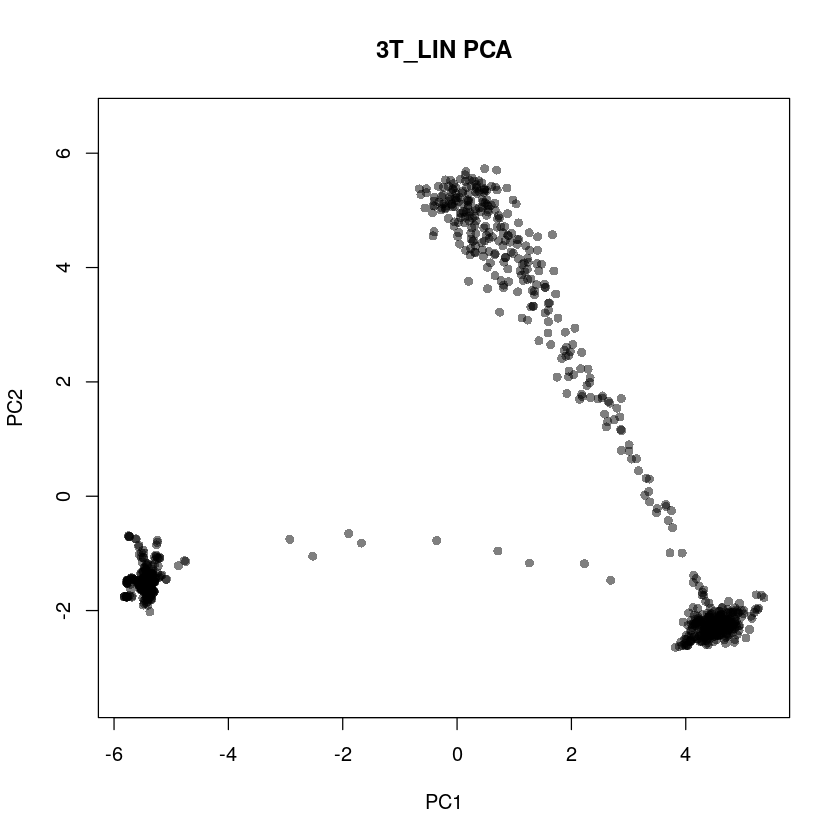

[1] "3T_LIN PCA kmeans"
[1] "3T_LIN UMAP kmeans"


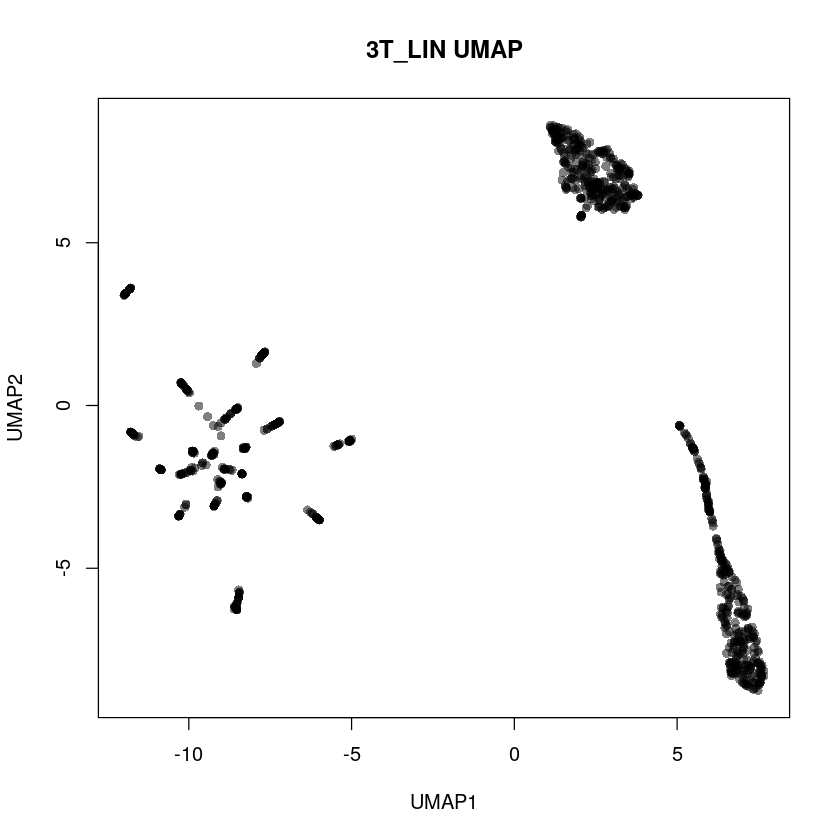

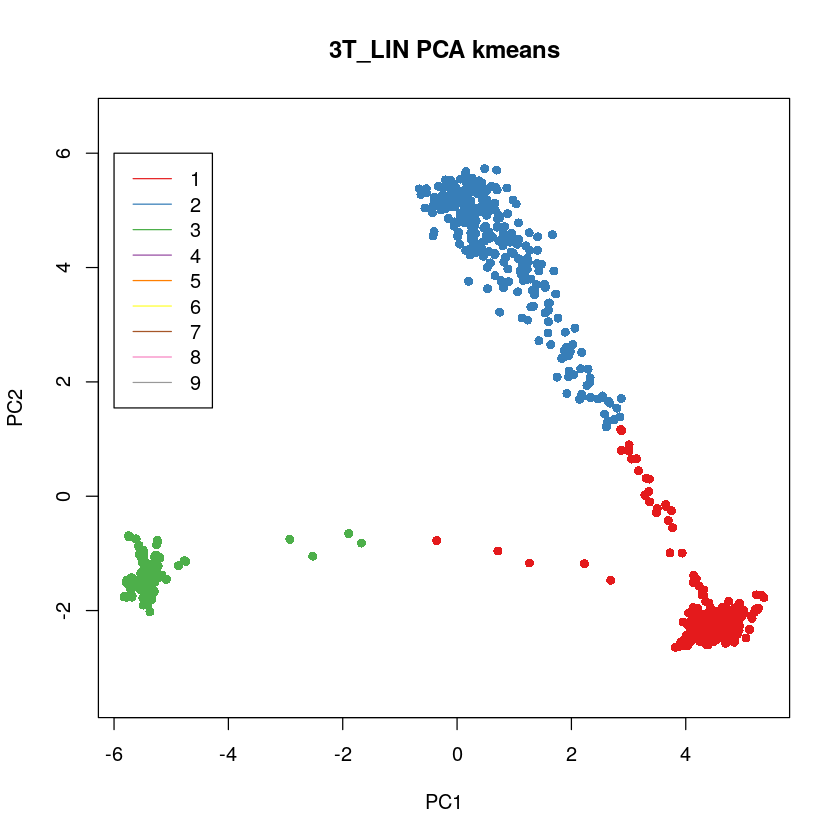

[1] "3T_LIN Slingshot"


Using full covariance matrix



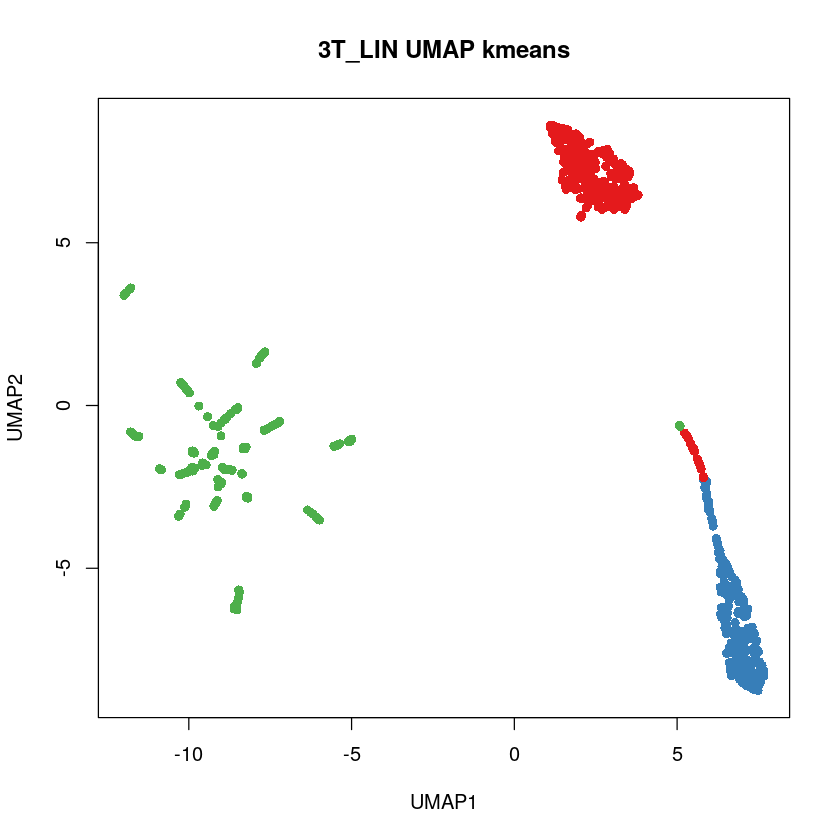

[1] "3T_LIN Slingshot PseudoTime summary"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.4559 10.4239  9.3172 16.4222 19.7838 


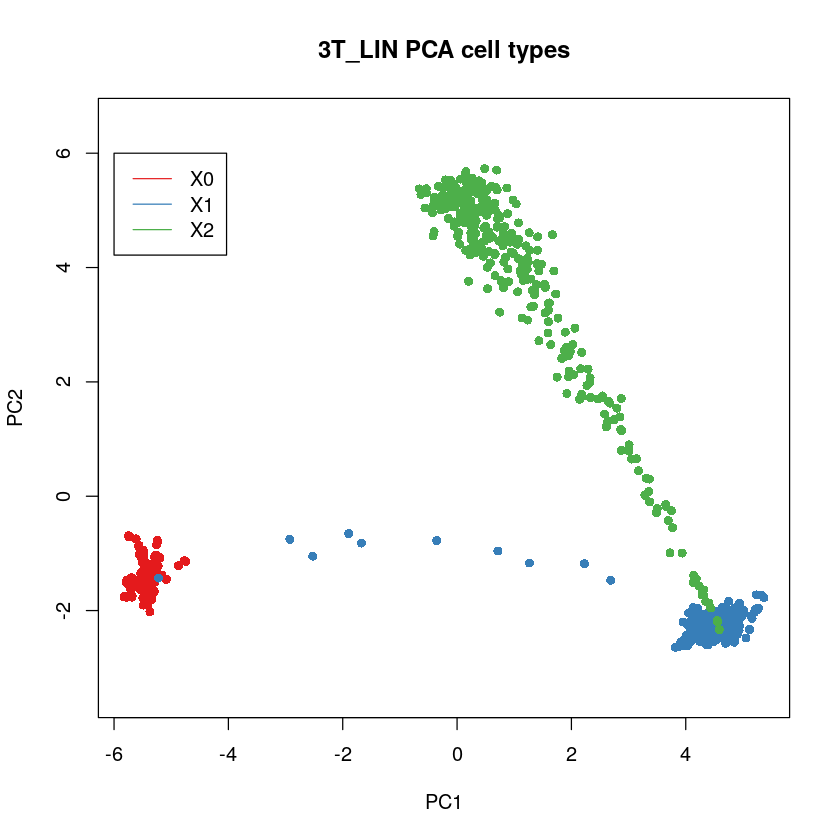

[1] "3T_LIN LOESS fit principal curves"
[1] "3T_LIN Slingshot principal curves"
[1] "PseudoTime1"


Warning message in dir.create(outdir, recursive = TRUE):
“'/scratch/ch153/packages/BEELINE/hlab1/Beeline/inputs_beeline/SERGIO_DS5/net0' already exists”


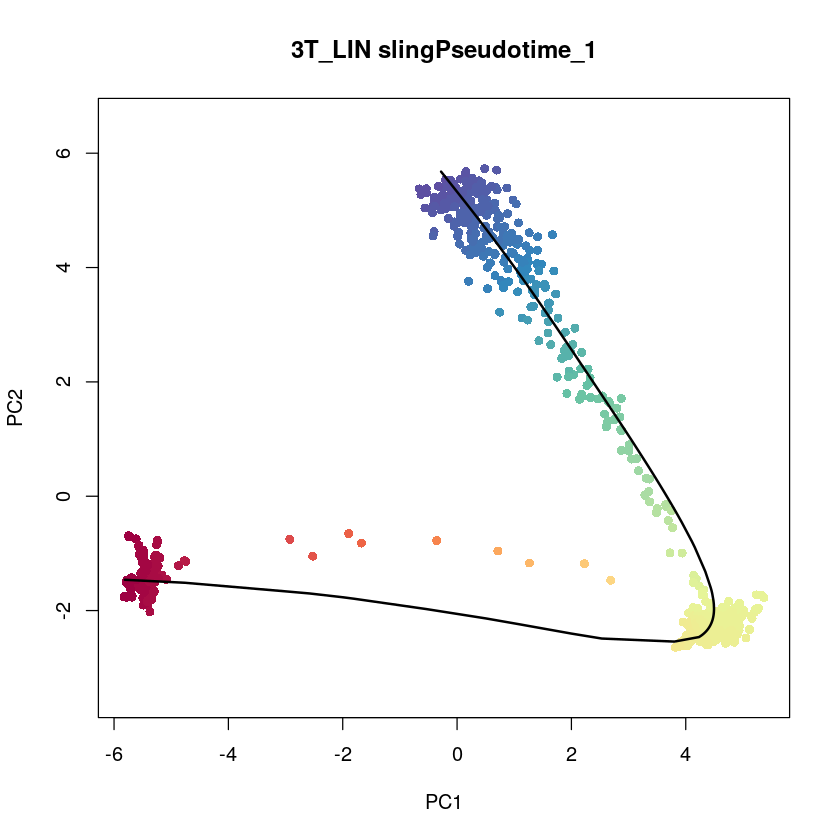

[1] "4T_BIF Expression data"
[1] "4T_BIF Cluster IDs"
[1] "4T_BIF SingleCellExperiment"
[1] "4T_BIF PCA"


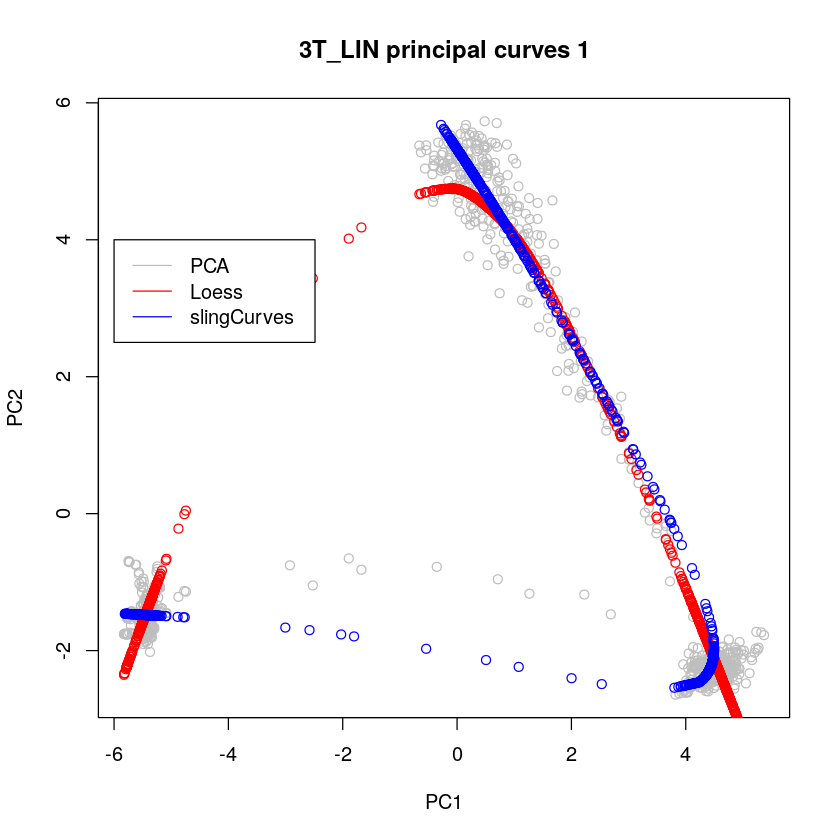

[1] "4T_BIF UMAP"


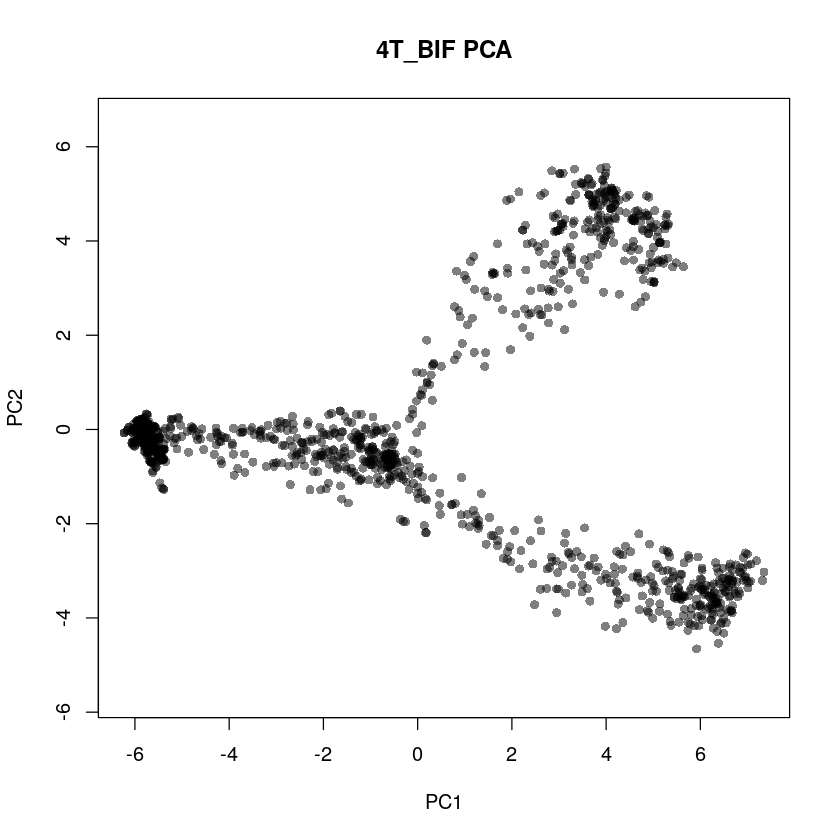

[1] "4T_BIF PCA kmeans"
[1] "4T_BIF UMAP kmeans"


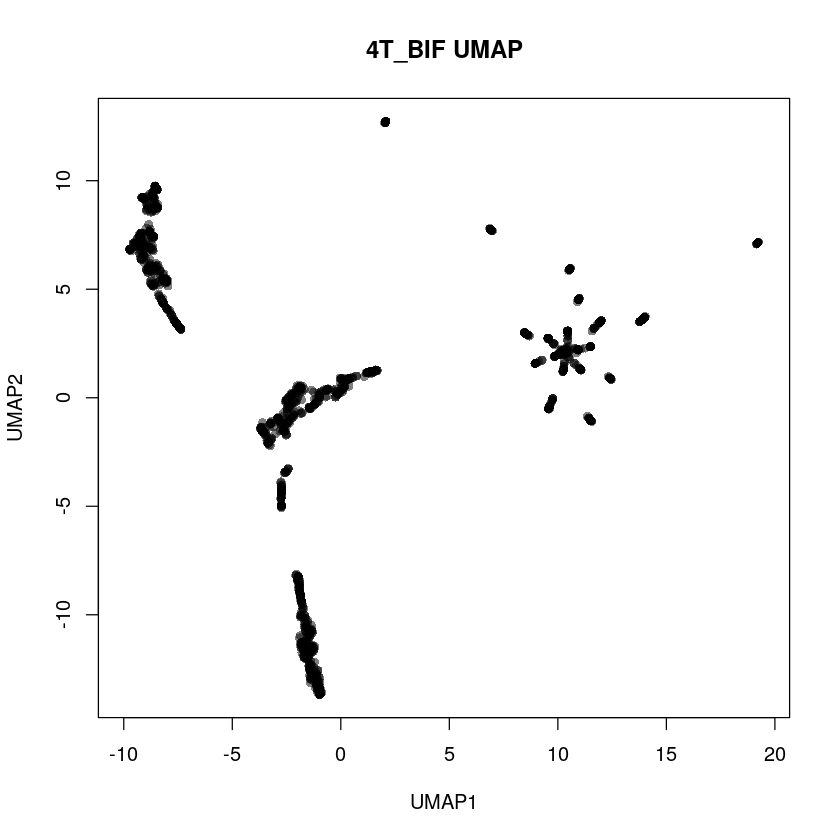

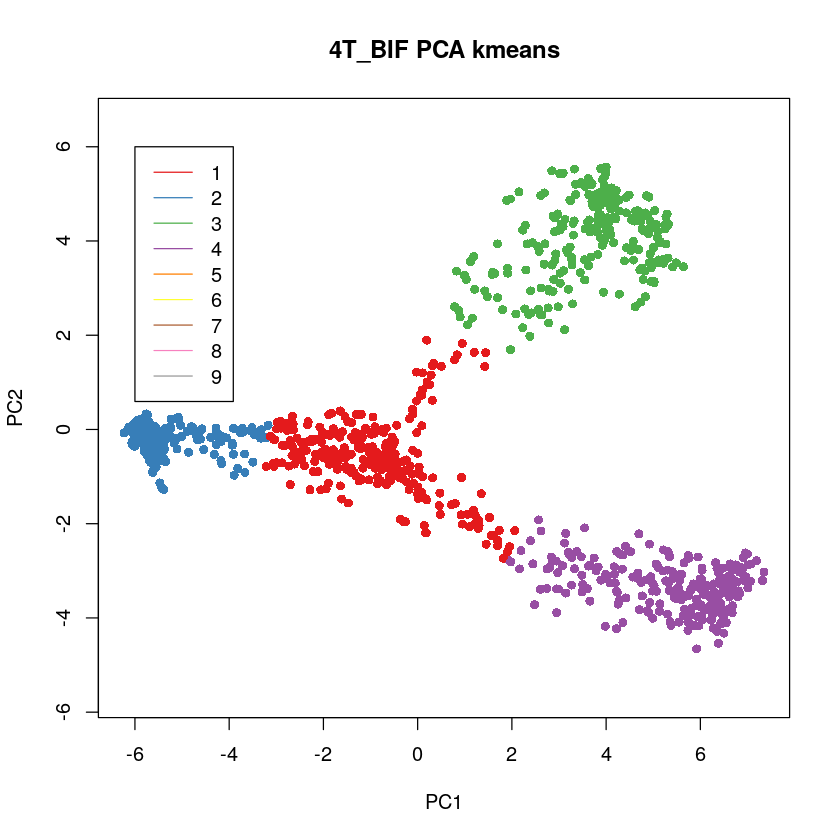

[1] "4T_BIF Slingshot"


Using full covariance matrix

Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to

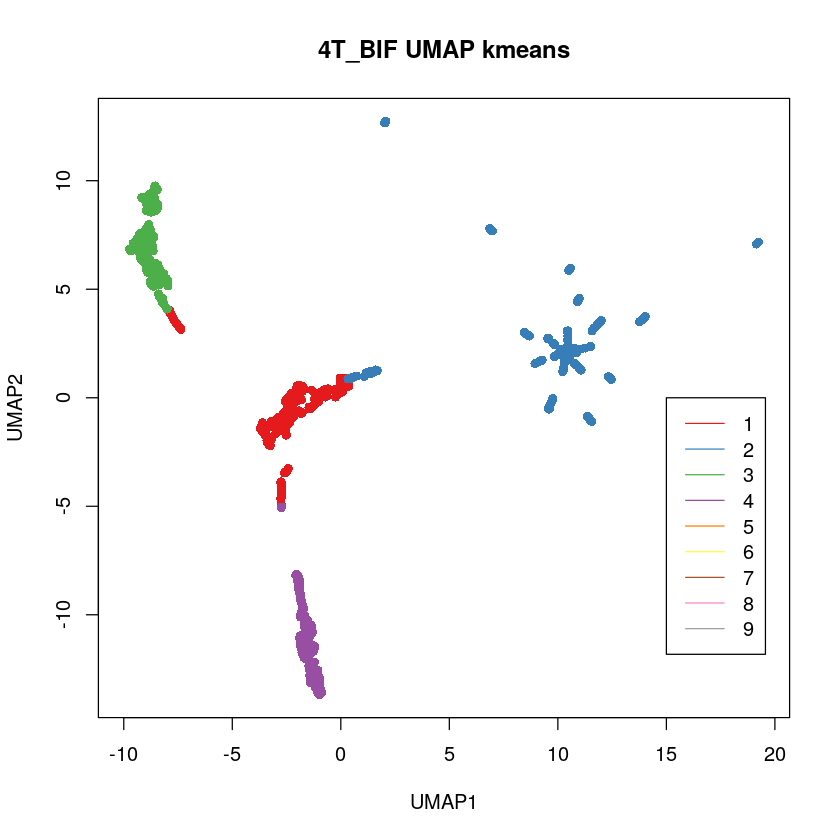

[1] "4T_BIF Slingshot PseudoTime summary"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.0000  0.5724  4.2902  5.2077 10.5667 13.0629     328 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.0000  0.5987  4.4947  5.3459 10.0838 14.0736     298 


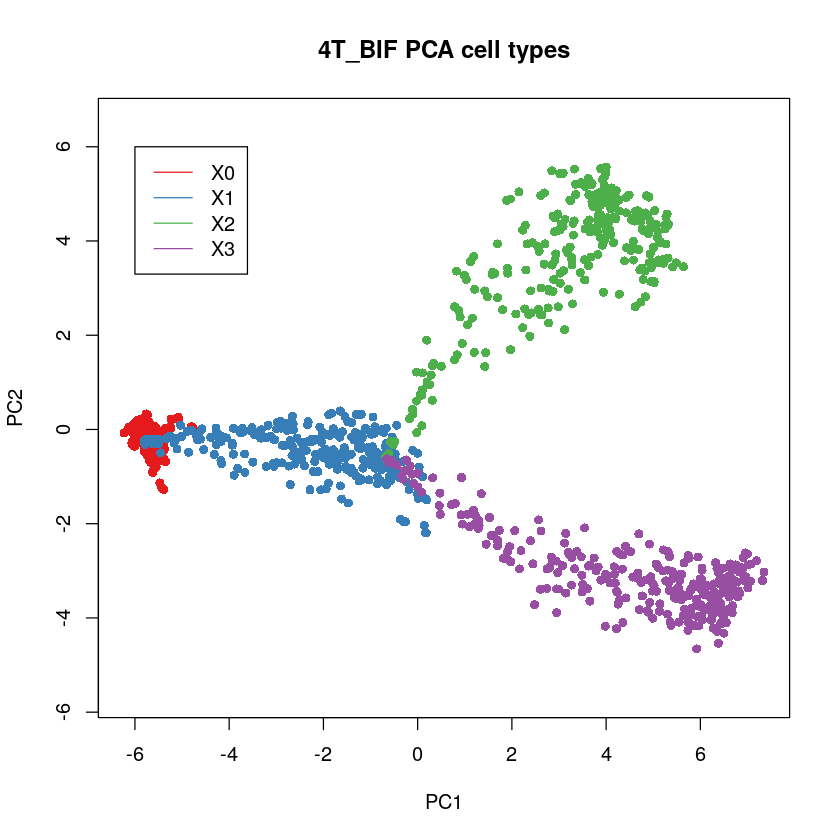

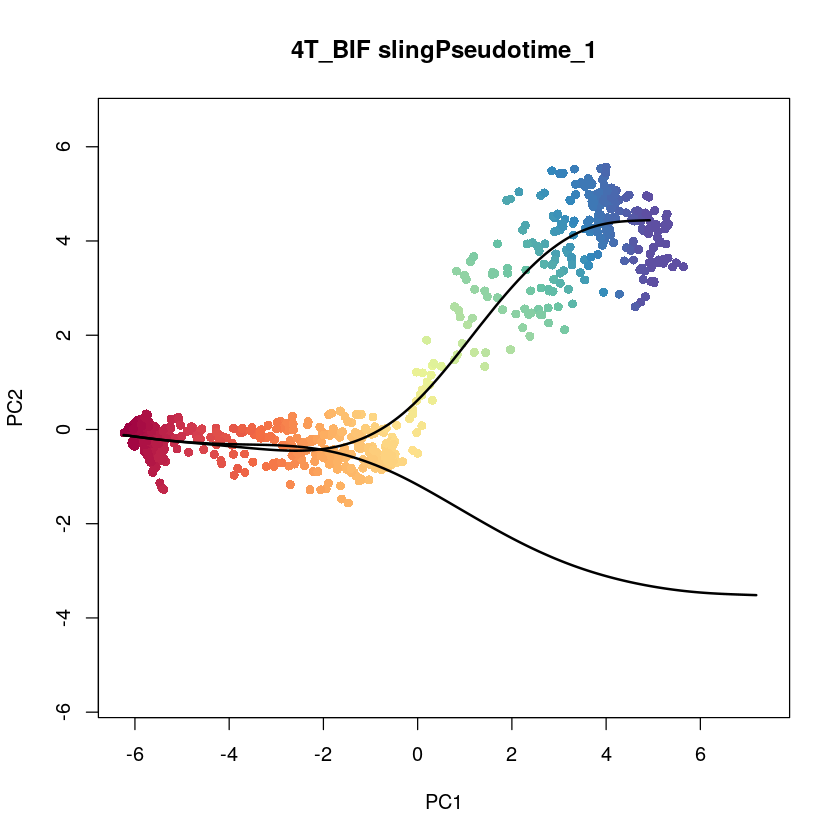

[1] "4T_BIF LOESS fit principal curves"
[1] "4T_BIF Slingshot principal curves"
[1] "PseudoTime1"
[1] "PseudoTime2"


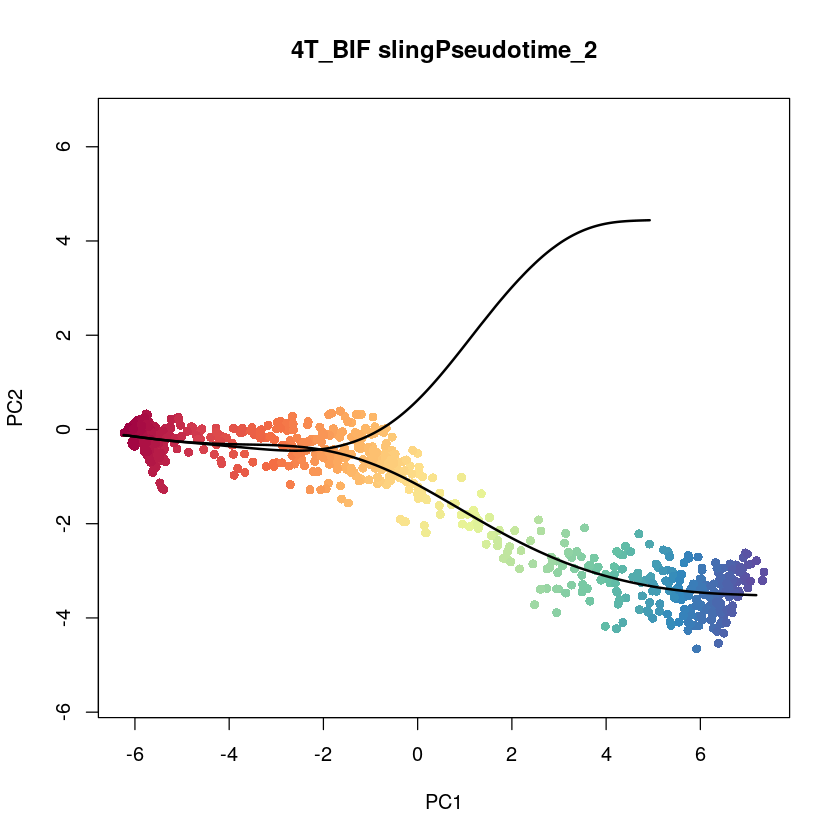

Warning message in dir.create(outdir, recursive = TRUE):
“'/scratch/ch153/packages/BEELINE/hlab1/Beeline/inputs_beeline/SERGIO_DS6/net0' already exists”


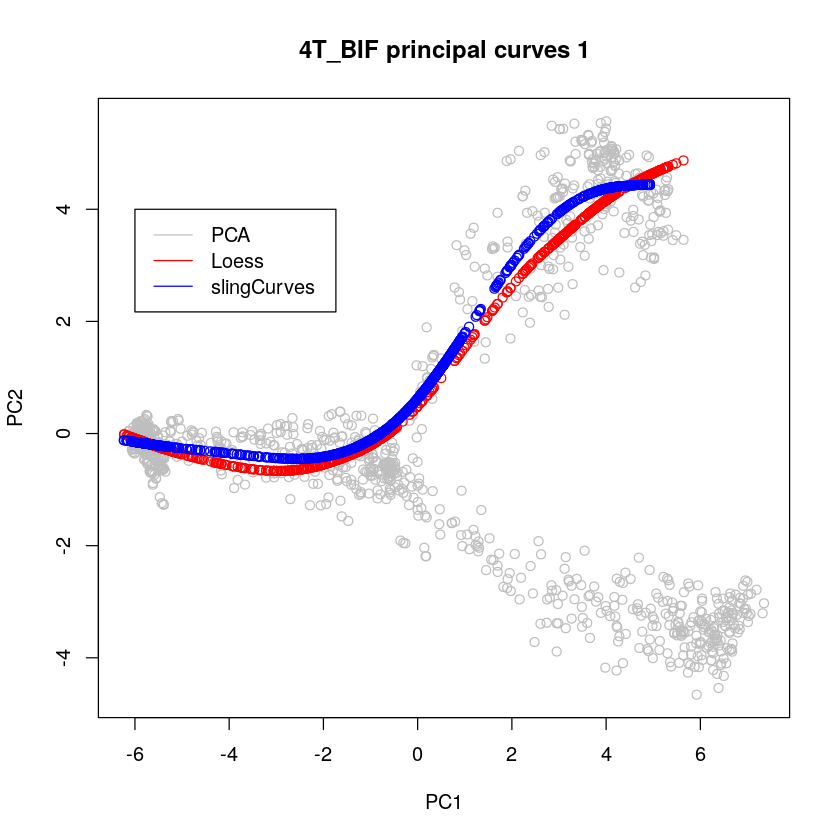

[1] "6T_TRIF Expression data"
[1] "6T_TRIF Cluster IDs"
[1] "6T_TRIF SingleCellExperiment"
[1] "6T_TRIF PCA"


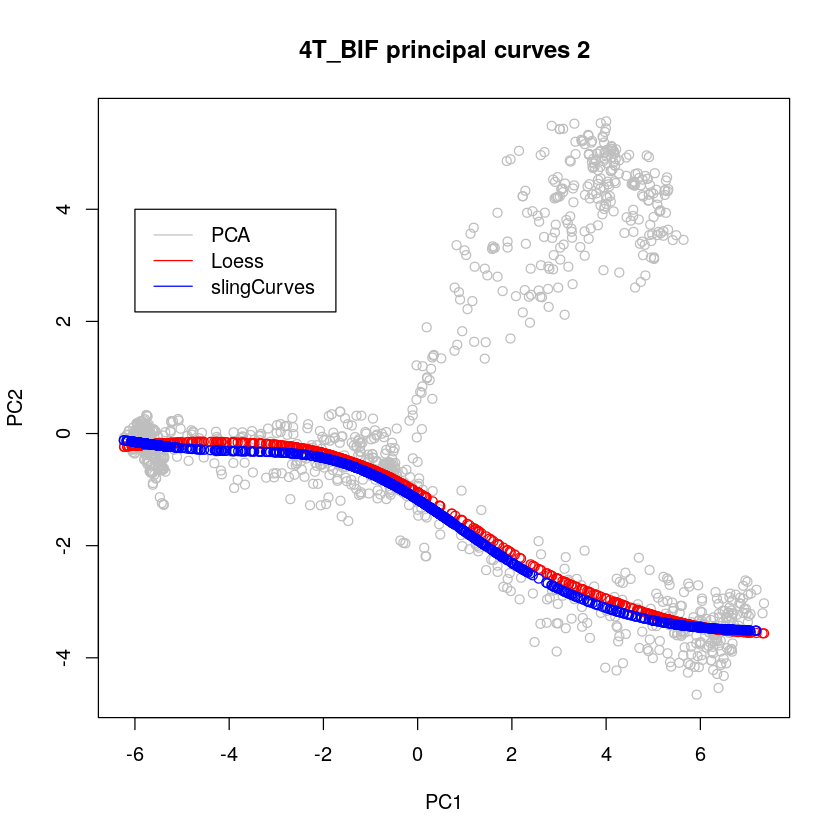

[1] "6T_TRIF UMAP"


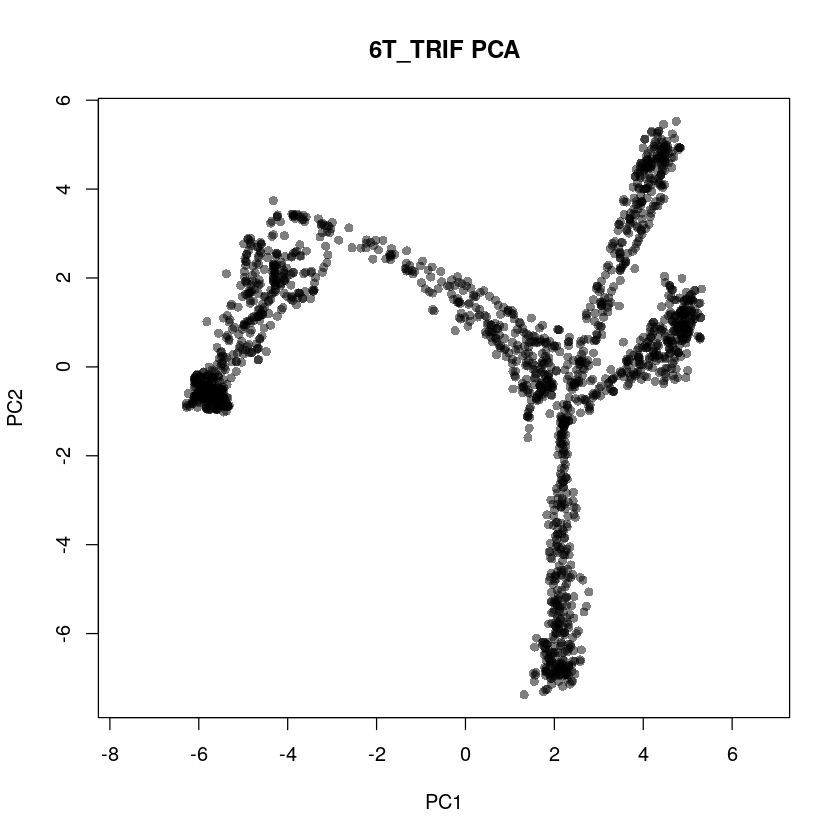

[1] "6T_TRIF PCA kmeans"
[1] "6T_TRIF UMAP kmeans"


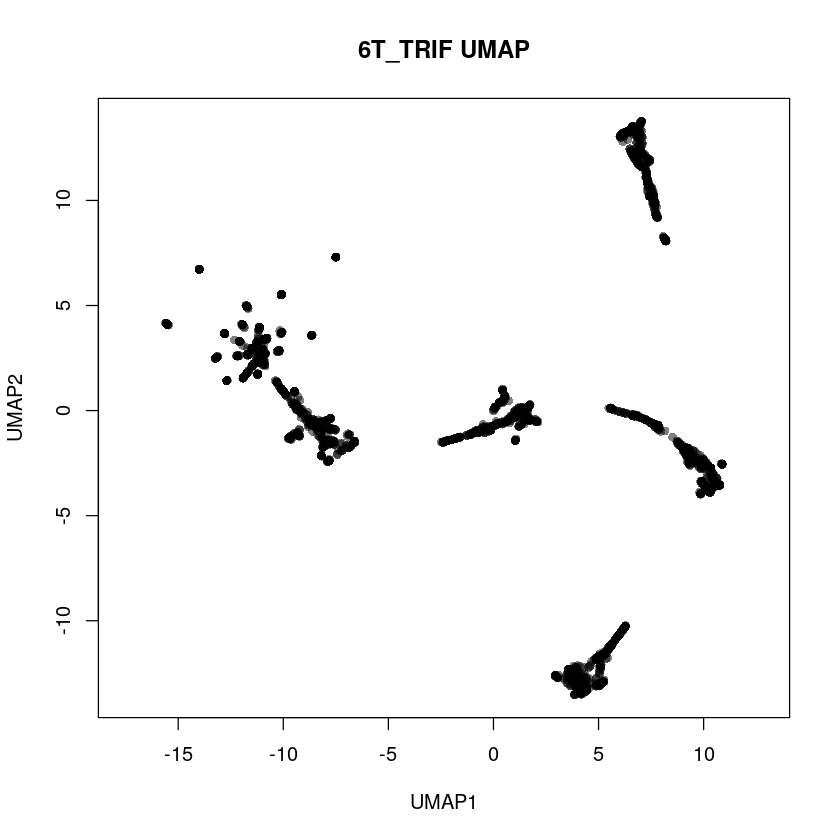

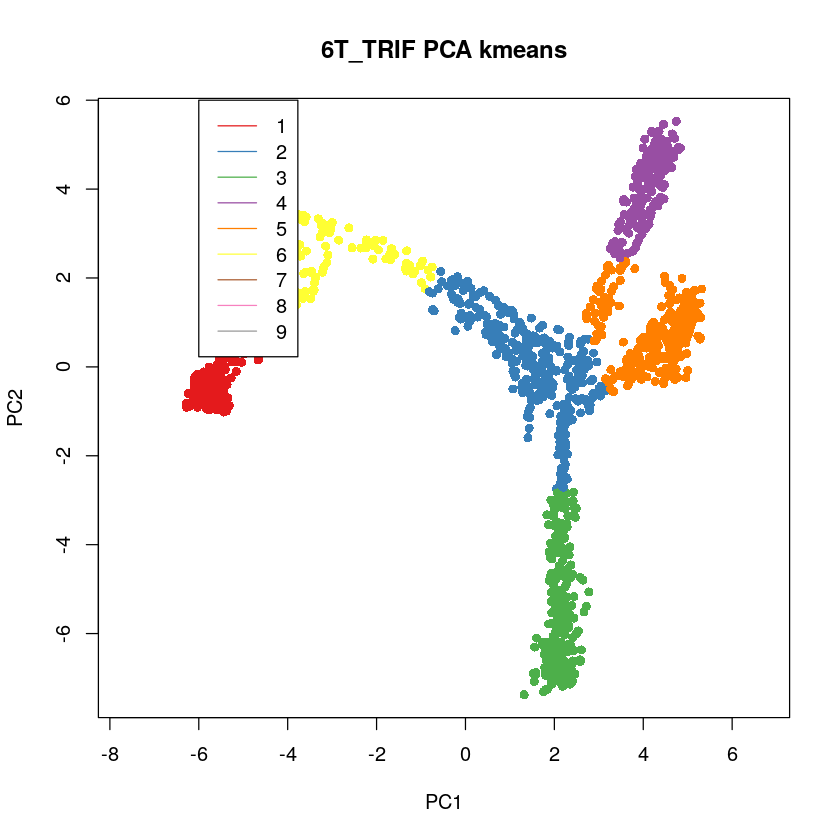

[1] "6T_TRIF Slingshot"


Using full covariance matrix

Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to

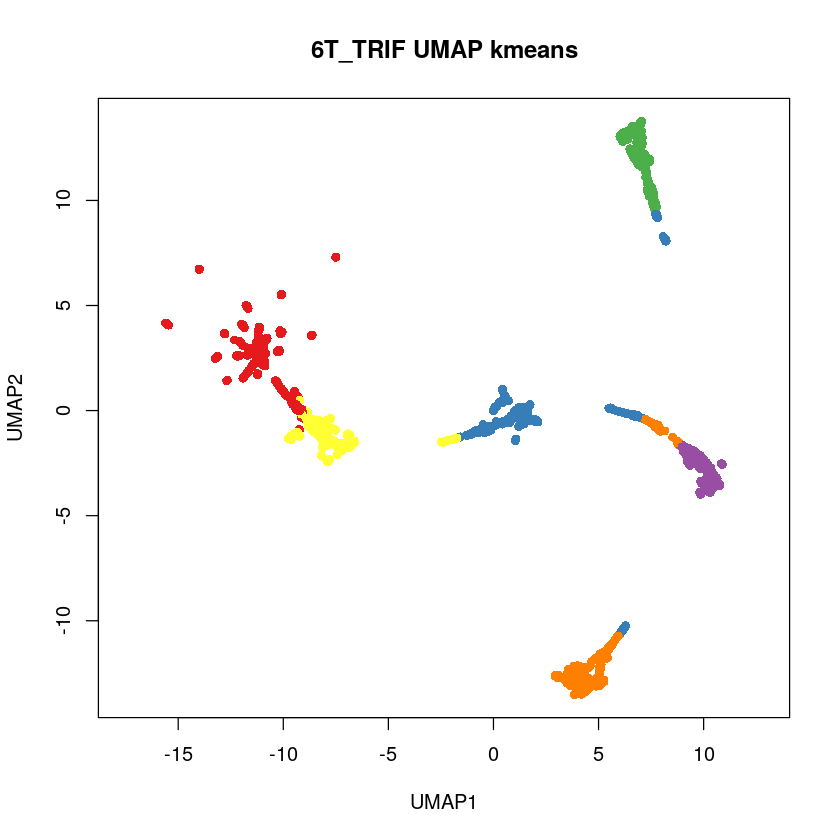

[1] "6T_TRIF Slingshot PseudoTime summary"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.0000  0.6135  3.7303  5.7782 10.1637 15.6158     708 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.0000  0.6981  4.4788  6.2623 11.1322 13.7773     588 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.0000  0.6716  4.3418  6.8114 11.6400 17.6764     603 


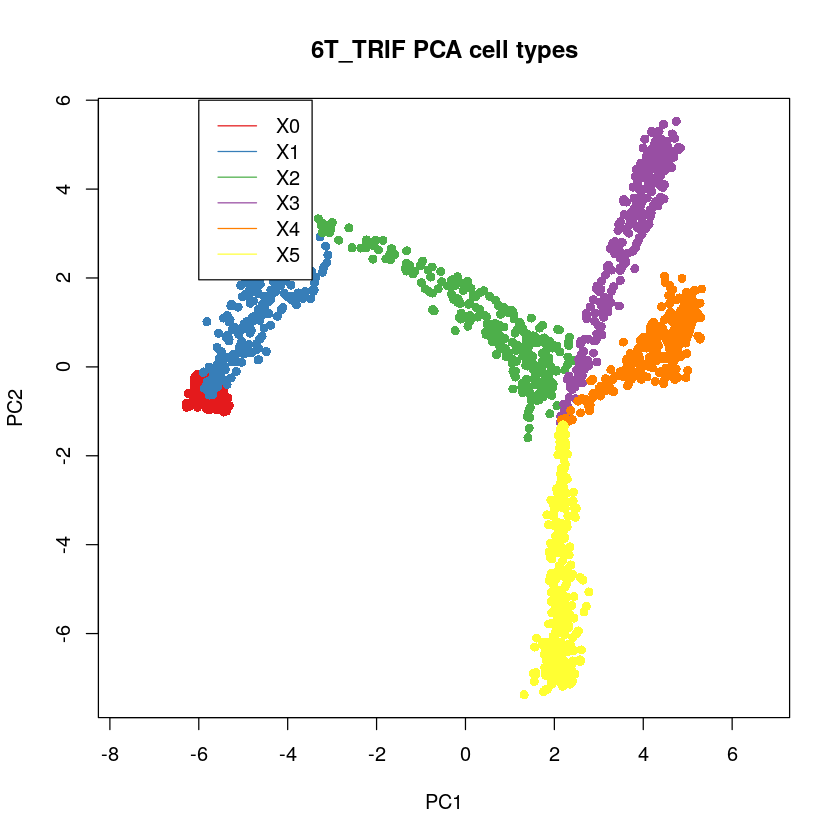

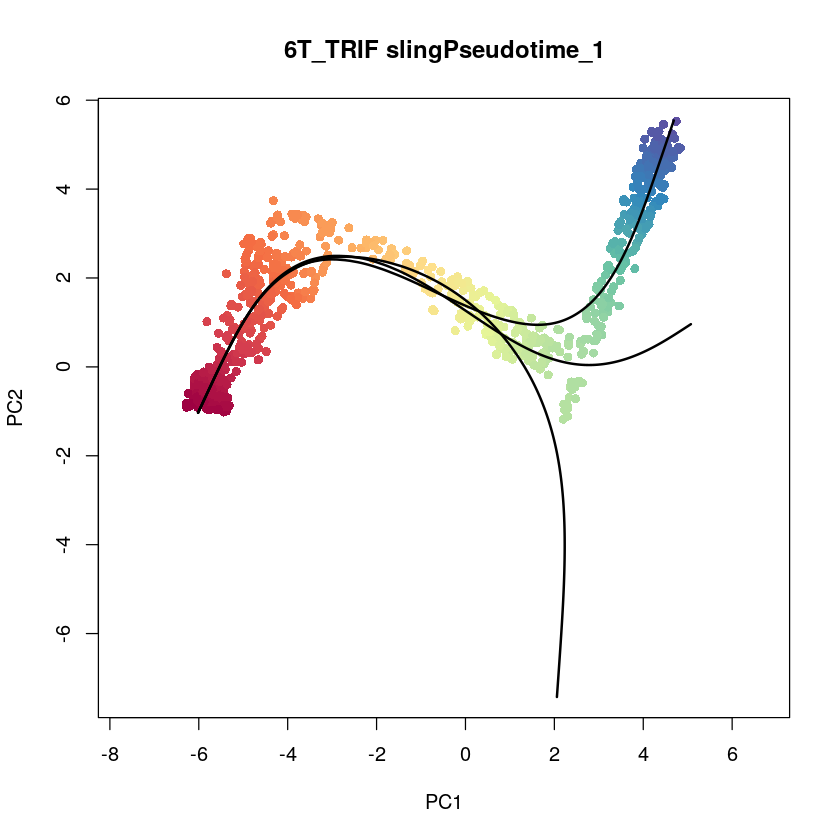

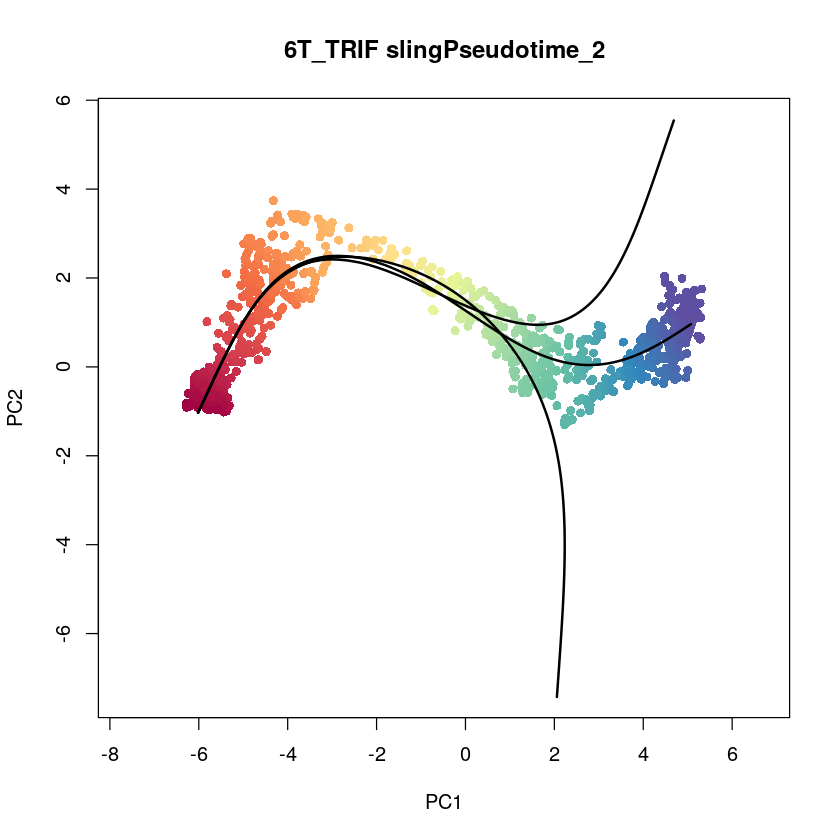

[1] "6T_TRIF LOESS fit principal curves"
[1] "6T_TRIF Slingshot principal curves"
[1] "PseudoTime1"
[1] "PseudoTime2"
[1] "PseudoTime3"


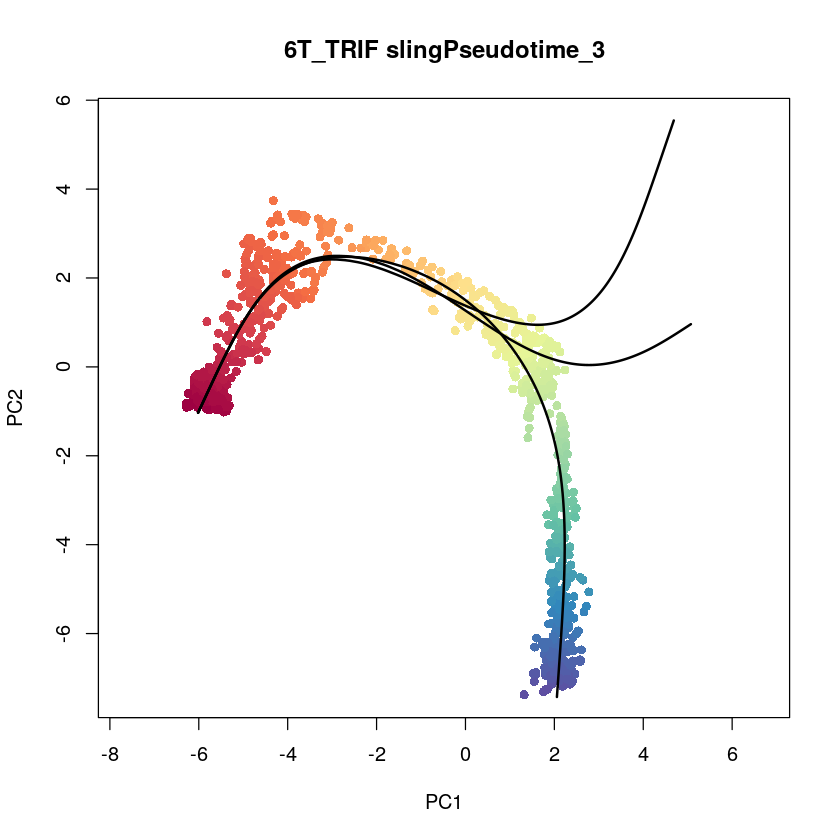

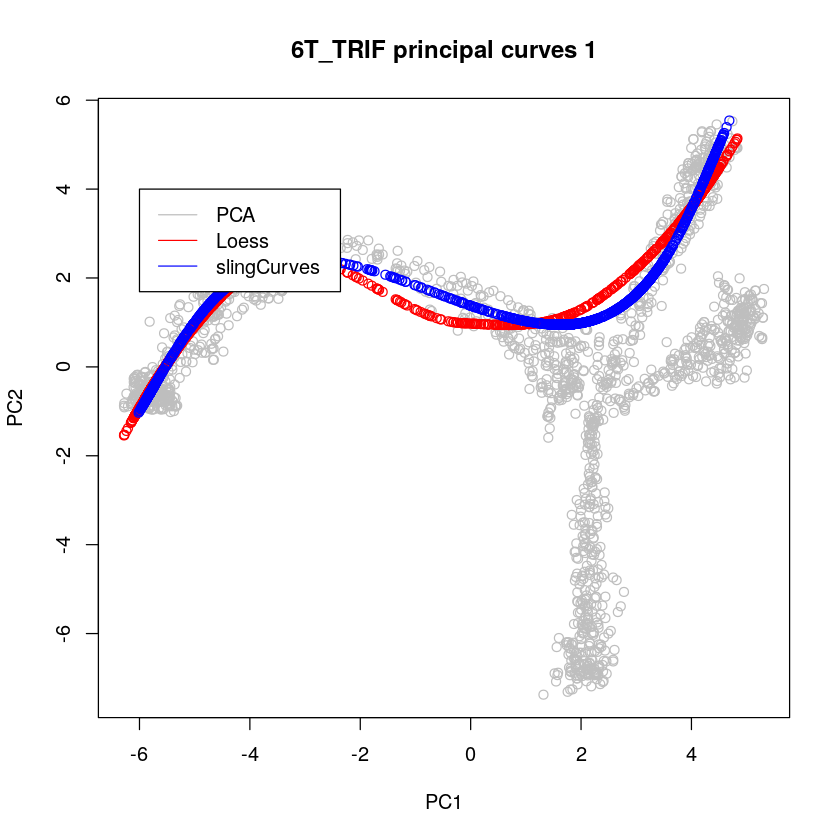

Warning message in dir.create(outdir, recursive = TRUE):
“'/scratch/ch153/packages/BEELINE/hlab1/Beeline/inputs_beeline/SERGIO_DS7/net0' already exists”


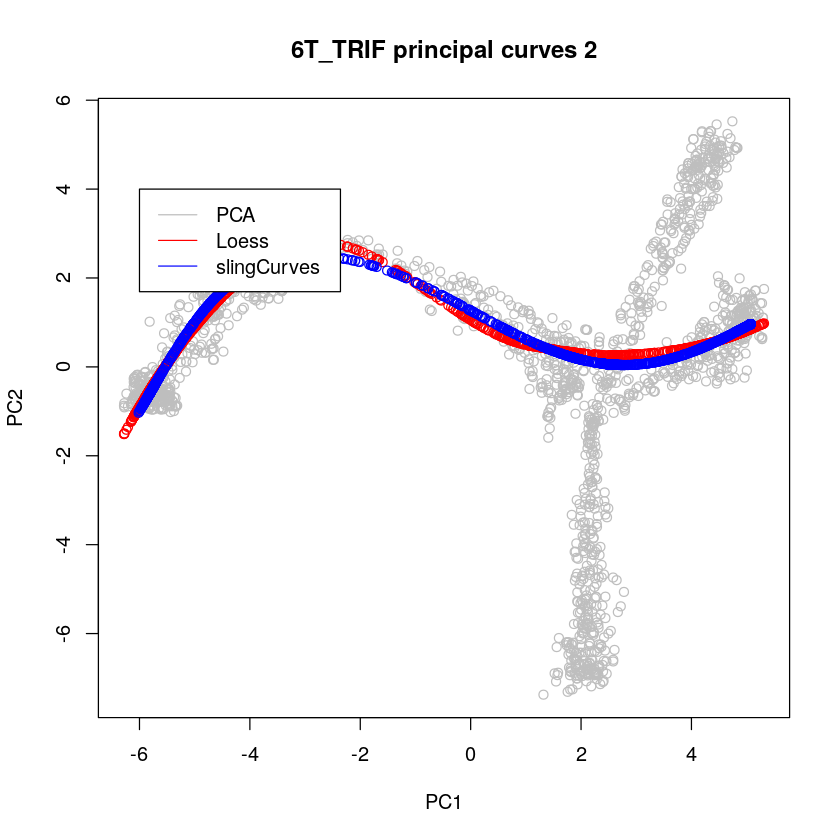

[1] "7T_TREE Expression data"
[1] "7T_TREE Cluster IDs"
[1] "7T_TREE SingleCellExperiment"
[1] "7T_TREE PCA"


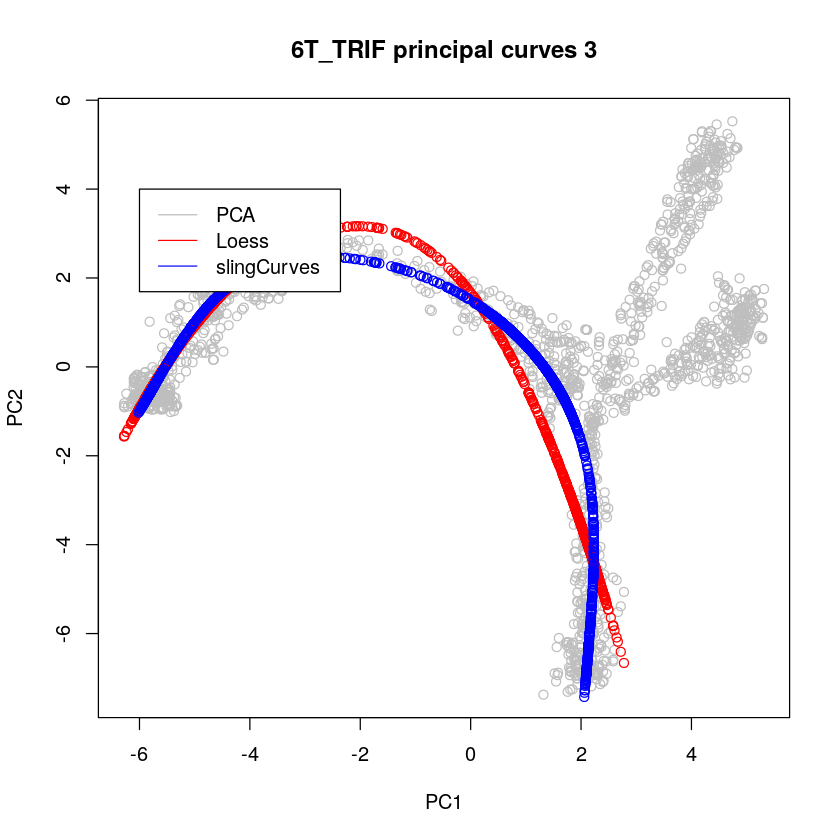

[1] "7T_TREE UMAP"


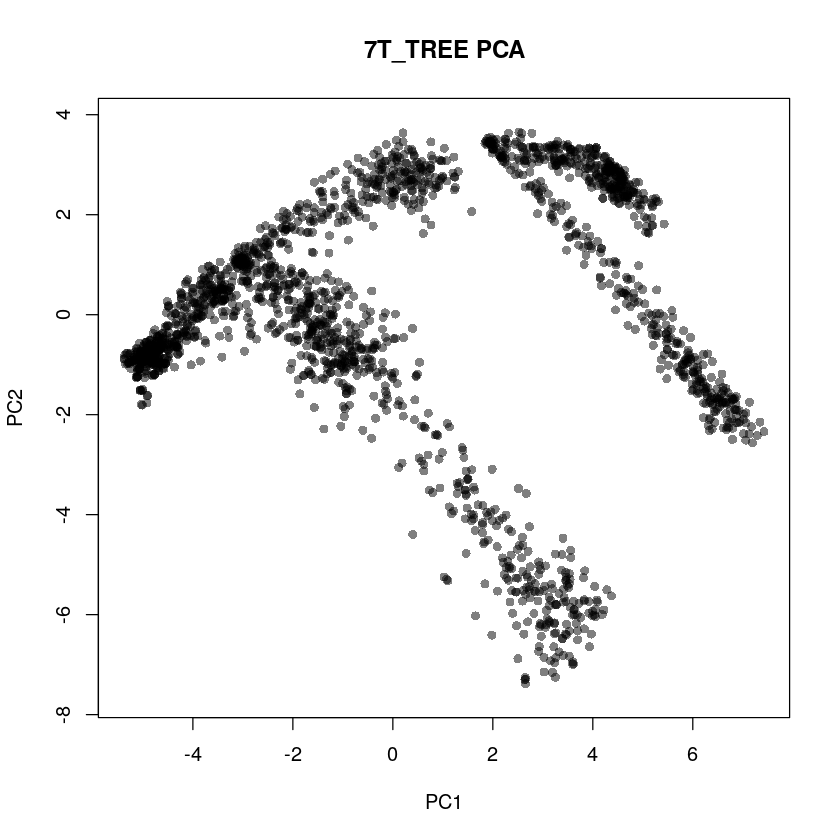

[1] "7T_TREE PCA kmeans"
[1] "7T_TREE UMAP kmeans"


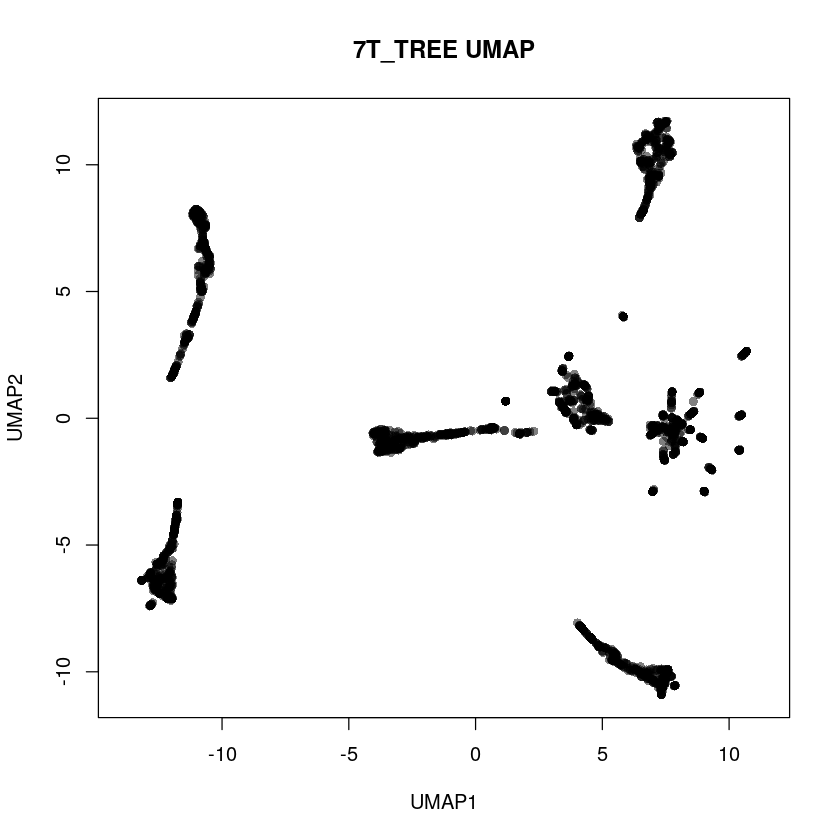

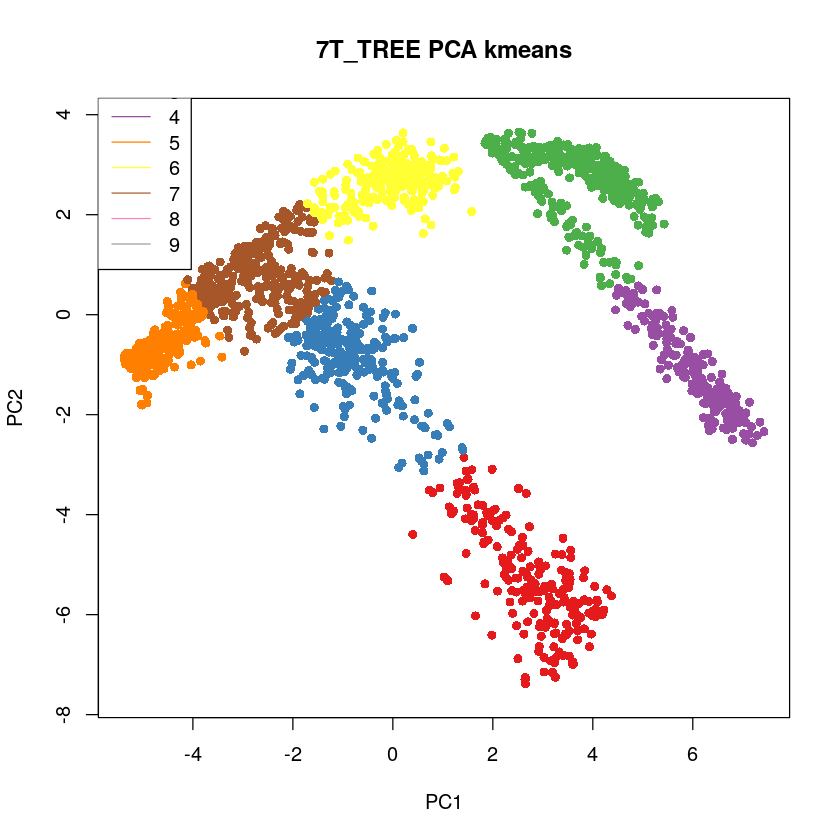

[1] "7T_TREE Slingshot"


Using full covariance matrix

Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to

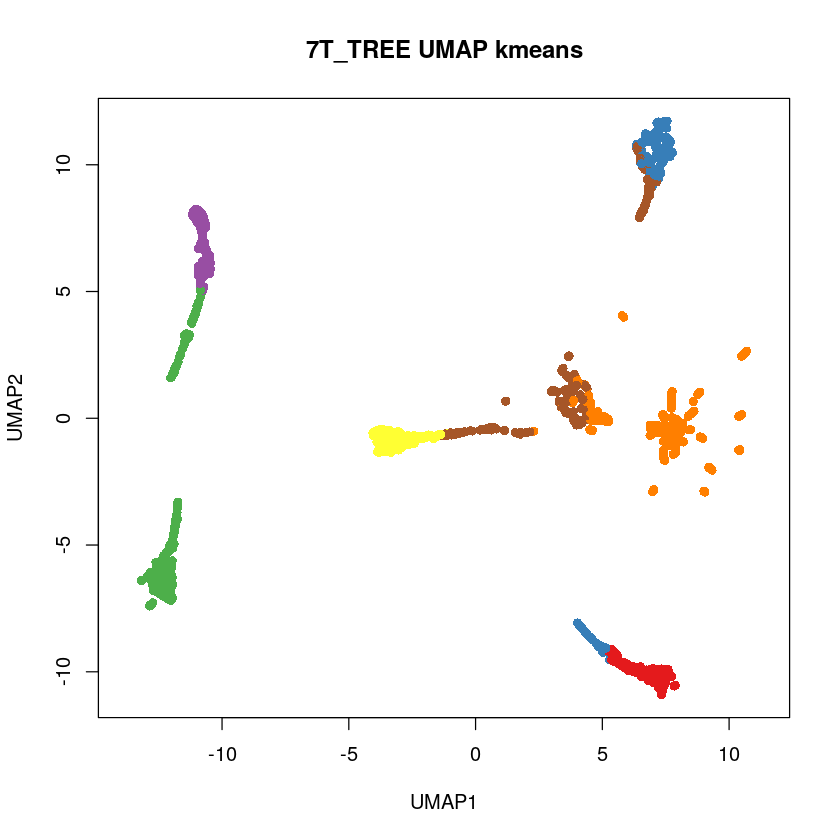

[1] "7T_TREE Slingshot PseudoTime summary"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   5.022  12.803  10.319  15.322  17.422     389 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   2.428  10.159   8.659  12.457  20.169     684 


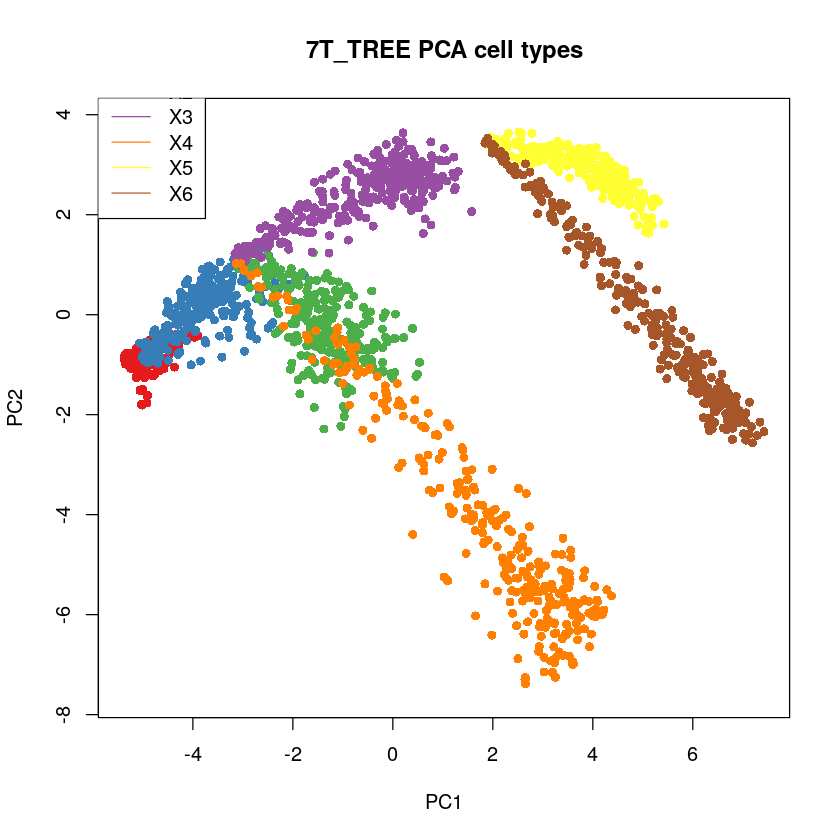

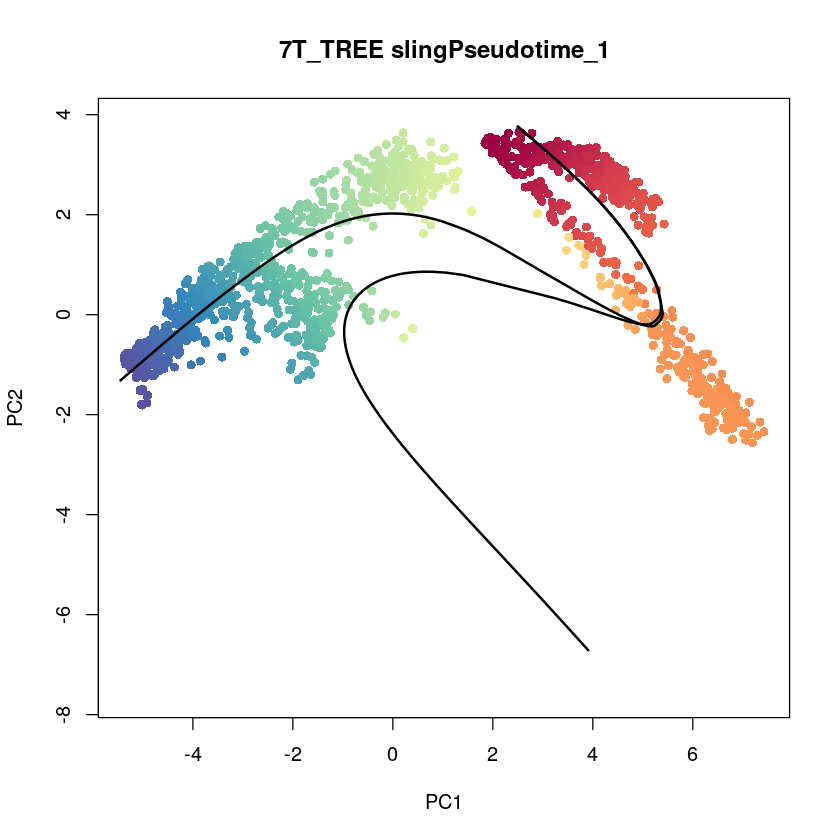

[1] "7T_TREE LOESS fit principal curves"
[1] "7T_TREE Slingshot principal curves"
[1] "PseudoTime1"
[1] "PseudoTime2"


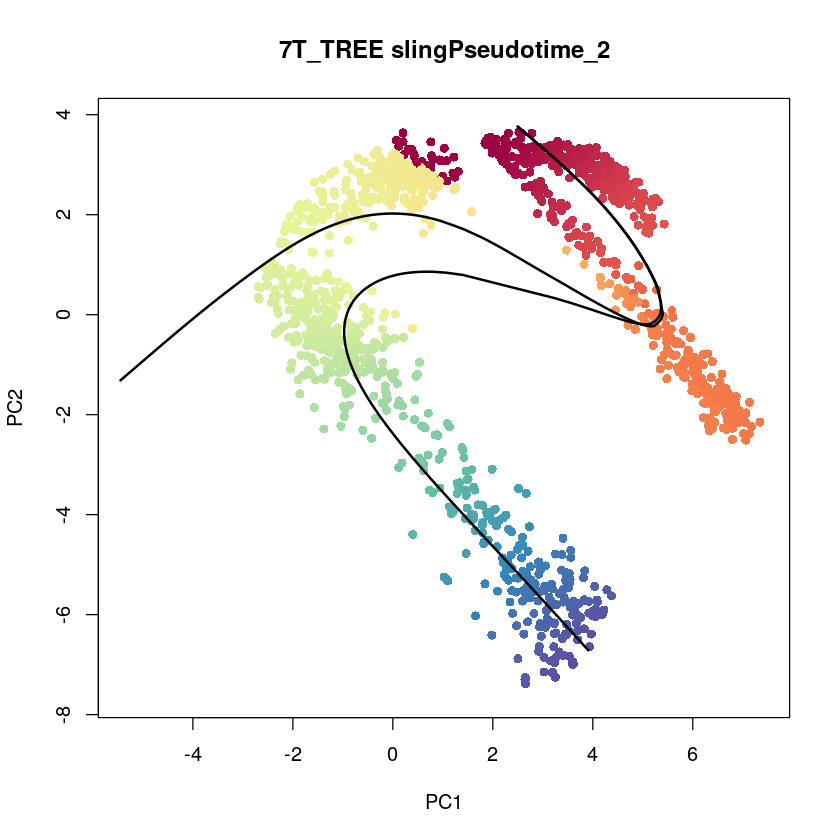

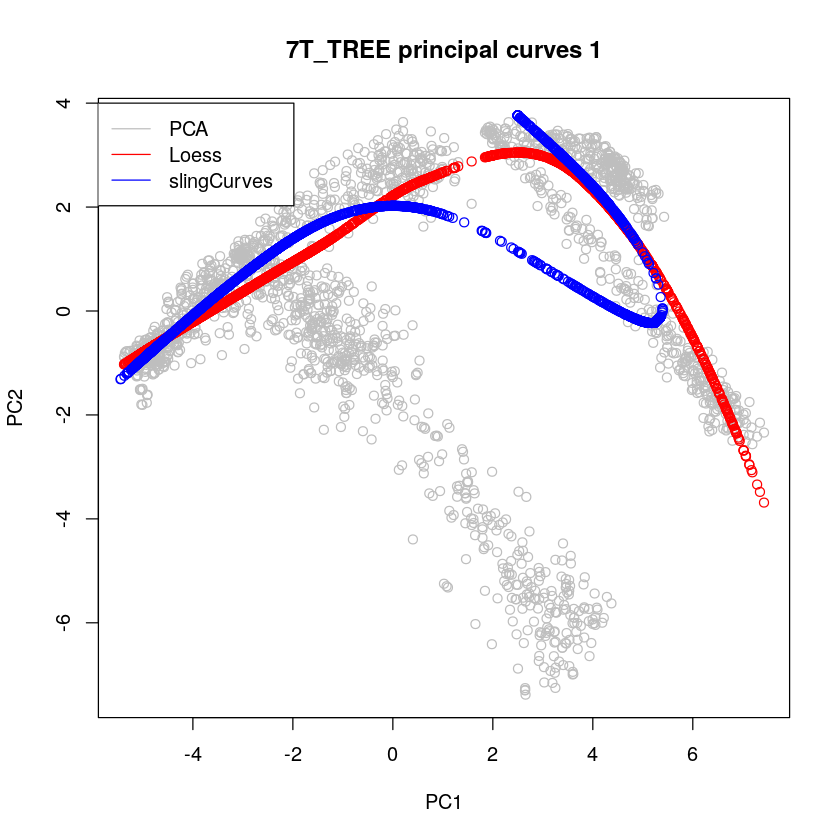

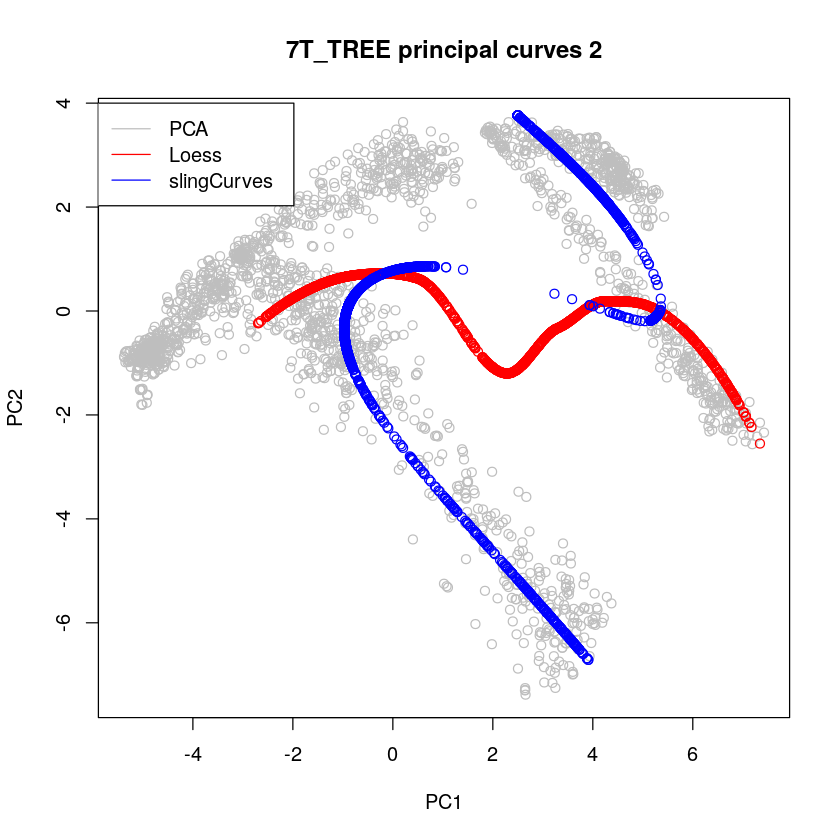

In [60]:
for (params_i in 5:nrow(SERGIO_DATASET_PARAMS)) {
    params_row = SERGIO_DATASET_PARAMS[params_i,]
    netfile = file.path(SERGIO_DATASETS_DIR,params_row[['source_dir']],'gt_GRN.csv')
    grn = read.table(netfile,sep=',',col.names=c('Gene1','Gene2'),stringsAsFactors=FALSE)
    grn[,'Gene1'] = paste0('G',grn[,'Gene1'])
    grn[,'Gene2'] = paste0('G',grn[,'Gene2'])
    grn[,'Type'] = 1
    for (net_i in c(0)) {
        outdir = file.path(INPUTS_BEELINE_DIR,params_row[['exp_dir']],paste0('net',net_i))
        dir.create(outdir,recursive=TRUE)
        # network file
        netout = file.path(outdir,'refNetwork.csv')
        write.table(grn,netout,sep=',',quote=FALSE,row.names=FALSE)
        
        # expression file
        expfile = file.path(SERGIO_DATASETS_DIR,params_row[['source_dir']],
                        str_interp(params_row[['expfile']],list(network_i=net_i)))        
        exp = read.table(expfile,sep=',',header=TRUE,row.names=1)
        rownames(exp) = paste0('G',rownames(exp))
        colnames(exp) = paste0('E',0:(ncol(exp)-1))
        expout = file.path(outdir,'ExpressionData.csv')
        write.table(exp,expout,sep=',',row.names=TRUE,col.names=TRUE,quote=FALSE)

        run_slingshot(expfile,params_row[['nclusters']],params_row[['desc']],outdir)
    }
}
